# Profiling Endothelial upon Eomes KD

In [1]:
here::i_am("rna_atac/differential/v2/02_endothelium.ipynb")

source(here::here("settings.R"))
source(here::here("utils.R"))

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(ArchR))

BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 16

# Multi core using future - built in to seurat
plan("multicore", workers = 16)
options(future.globals.maxSize = 50 * 1024 ^ 3) # for 50 Gb RAM



here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code

Warning message:
“package ‘rtracklayer’ was built under R version 4.2.3”

                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | 

In [145]:
# Define custom functions
plot_region = function(input_gene, gene_height = 1.5, no_label = F, bw_width = 10, bw_height = 10, extend.upstream = 3e3, extend.downstream = 3e3, expr_width = 4.5){
    tmp1 = DEG_DAR[celltype %in% args$celltypes & gene %in% input_gene] %>% 
        .[order(-abs(ATAC_logFC))] %>% unique(by = 'peak')
    gene_region = ArchRProject@geneAnnotation$genes[grep(paste0('^', input_gene, '$'), ArchRProject@geneAnnotation$genes$symbol)]
    peak_regions = as.numeric(str_split(str_split(tmp1$peak, ':') %>% map_chr(2), '-') %>% map_chr(1))
    start = min(c(start(ranges(gene_region)), peak_regions)) - extend.downstream
    end = max(c(c(end(ranges(gene_region)), peak_regions + 600))) + extend.upstream
    input_region = paste0(gene_region@seqnames@values, ':', start, '-', end)

    mypal <- colorRampPalette(c("#f5ee71","grey98","#d0ffc2"))(100)
    x <- tmp1[, ATAC_logFC]
    # highlight_colors = map2color(x,mypal, limits = c(-max(abs(c(0,x))), max(abs(c(0,x)))))
    highlight_colors = ifelse(x > 0, "#b8fca4", "#80fff9")
    names(highlight_colors) = str_split(str_split(tmp1[, peak], ':') %>% map_chr(2), '-') %>% map_chr(1)

    plot_browser_track(gene = input_gene, # gene used for plotting expression
                                  input_region = input_region, # Region used
                                  bigwigs = WT_plot, 
                                  extend.upstream = 0,
                                  extend.downstream = 0, 
                                  highlight_regions = if(length(tmp1$peak)>0){tmp1$peak}else{NULL},
                                  downsample.rate = 1, 
                                  no_label = no_label, 
                                  plot_expression = T,
                                  background_color = 'white',
                                  highlight_color = if(length(highlight_colors)>0){highlight_colors}else{NULL},
                                  bw_height = bw_height, 
                                  gene_height = gene_height,
                                  bw_width = bw_width,
                                  expr_width = expr_width)
}

plot_enr_heatmap = function(motif_enrichment, ntop=25, TFs = NULL, title = 'Motifs in marker peaks', subtitle = NULL, color = 'darkblue') {

    if(!is.null(TFs)){
        keep_tfs = TFs
    }else{
        keep_tfs = motif_enrichment %>% .[,variable:=factor(celltype, levels= names(opts$celltype_v2.colors))] %>% .[order(c(celltype, -mlog10Padj))] %>% .[, head(.SD, ntop),  by=celltype] %>% .$feature   
    }
    
    enriched.dt = motif_enrichment[feature %in% keep_tfs] %>% .[order( -mlog10Padj)] %>% 
        #.[,TF:=strsplit(TF, '_') %>% map_chr(1)] %>%
         .[,feature:=factor(feature, levels=unique(keep_tfs))] %>%
        .[,variable:=factor(celltype, levels=names(opts$celltype_v2.colors))]
    
    p = ggplot(enriched.dt, aes(feature, celltype, color = Enrichment, size=mlog10Padj)) + 
        geom_point() +
        scale_color_gradient2(low='white', mid = 'white', high=color, name='Enrichment', midpoint = 0) + # , breaks = c(0,100), labels = c('Min', 'Max')
        scale_size(range = c(-0.3, 2.7), limits = c(0, max(enriched.dt$mlog10Padj)), 
                breaks = round(seq(5, max(enriched.dt$mlog10Padj), max(enriched.dt$mlog10Padj)/3), -0.5),
                name = '-log10(FDR)') + 
        scale_y_discrete(expand = c(0, 0.5)) + 
        scale_x_discrete(expand = c(0, 0.5)) + 
        geom_hline(yintercept=seq(.5, 20, 1), alpha=0.2) + 
        geom_hline(yintercept=c(6.5, 7.5), alpha=1) + 
        guides(colour = guide_colourbar(
            # barwidth = 1, barheight = 1,
            frame.colour = "black", 
            ticks.colour = "black"
        )) + 
        labs(title = title, caption = subtitle) + 
        theme(text=element_text(size=12), 
             axis.text = element_text(color='black'),
             axis.text.x=element_text(angle=-90,hjust=0,vjust=0.5, size=12), 
             axis.text.y= element_text(hjust=1, size = 12), # element_blank(), #
             axis.title = element_blank(),
             panel.border = element_rect(color='black', linewidth=1, fill = NA),
             panel.background = element_blank(),
             plot.title = element_text(size=14, face='plain', hjust=0.5),
             axis.line = element_blank(),
             legend.title = element_text(hjust=0, vjust = 0.85),
             legend.text = element_text(hjust=0.5, vjust = 0.5),
             legend.position = 'bottom',
             legend.key = element_blank()
        )
    
p
    return(p)
}

In [3]:
args = list()

# Metadata
args$metadata = file.path(io$basedir, 'results/rna_atac/clustering/metadata_celltype_annotated_v2.txt.gz')

# RNA_sce
args$rna_sce = file.path(io$basedir, 'processed/rna/SingleCellExperiment.rds')

# Load Differential analysis
args$expression = file.path(io$basedir, 'results/rna_atac/differential/v2/expression/')
args$accessibility = file.path(io$basedir, 'results/rna_atac/differential/v2/Accessibility/')
args$WT_trajectory = file.path(io$basedir, 'results/rna_atac/trajectory/v3')

# outdir
args$outdir = file.path(io$basedir, 'results/rna_atac/differential/v2/02_endothelium/')
dir.create(args$outdir, recursive=TRUE, showWarnings =FALSE)

# Celltypes to use
args$celltypes = c('Endothelium')

# multiome atlas endothelium 
args$atlas_sce = '/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/results/endothelium/endothelium_sce.rds'

In [4]:
# Load browser track files
ArchRProject = suppressMessages(ArchR::loadArchRProject(io$archR.directory))
args$atlas_bws = '/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/data/processed/atac/archR/GroupBigWigs/cluster/'
args$vitro_bws = file.path(io$basedir, 'processed/atac/archR/GroupBigWigs/celltypeV2_genotype/')

opts$endo_celltype.colors = c(
    'Allantois_endothelium' = '#2f4a60', 
    'EP_endothelium' = '#90e3bf', 
    'Unknown_endothelium' = '#AE3F3F', 
    'YS_endothelium' = '#ff891c'
)

bigwigs.data_vitro = data.table(celltype = list.files(args$vitro_bws, 'bw') %>% str_split(., '\\.') %>% map_chr(1),
                    genotype = list.files(args$vitro_bws, 'bw') %>% str_split(., '\\.') %>% map_chr(2) %>% str_split('-') %>% map_chr(1),
                    path =  paste0(args$vitro_bws, list.files(args$vitro_bws, 'bw'))) %>% 
                .[,name := gsub('KO', 'KD', paste0(celltype, ' ', genotype))] %>% 
                .[,color := ifelse(genotype == 'KO', '#FF0000', '#000000')]

bigwigs.data_vivo = data.table(celltype = list.files(args$atlas_bws, 'bw') %>% str_split(., '-') %>% map_chr(1),
                    genotype = 'Atlas',
                    path =  paste0(args$atlas_bws, list.files(args$atlas_bws, 'bw'))) %>% 
                .[,name := paste0(celltype, ' (Atlas)')] %>% 
                .[,color := opts$endo_celltype.colors[celltype]]

bigwigs.data = rbind(bigwigs.data_vitro, bigwigs.data_vivo)


In [5]:

bigwig_order = c(#'Unknown_endothelium (Atlas)',
                 #'EP_endothelium (Atlas)',
                 'YS_endothelium (Atlas)',
                 'Allantois_endothelium (Atlas)',
                 'Endothelium WT',
                 'Endothelium KD'
                 #'Allantois-WT'
                )

WT_plot = bigwigs.data %>% copy() %>%
    .[match(bigwig_order, name)] %>% 
    .[, name := factor(name, levels = bigwig_order)]

In [6]:
# Load meta
meta = fread(args$metadata)[day!='D3']

#### Load Data

In [7]:
# load sce
rna.sce <- load_SingleCellExperiment(args$rna_sce, normalise = TRUE, cells = meta$cell)
colData(rna.sce) = meta %>% as.data.frame() %>% tibble::column_to_rownames('cell') %>% DataFrame()

In [8]:
# Load differential RNA
DEGs = fread(sprintf('%s/DEGs_edgeR_pb.txt.gz', args$expression))[celltype %in% args$celltypes] %>% 
        .[,sig:=ifelse(abs(logFC)>0.5 & padj_fdr < 0.05, TRUE, FALSE)] %>% 
        .[sig == T] %>% .[, sig := NULL]
DEGs = DEGs[!gene %in% c('Hba-x', 'Hba-a1', 'Hba-a2', 'Hbb-bh1')]

# Load differential ATAC
DARs = fread(sprintf('%s/DARs_edgeR_pb.txt.gz', args$accessibility))[celltype %in% args$celltypes] %>% 
        .[,sig:=ifelse(abs(logFC)>0.5 & padj_fdr < 0.05, TRUE, FALSE)] %>% 
        .[sig == T] %>% .[, sig := NULL]

# Load peak2gene linkage
peak_gene_correlation = fread(file.path(args$WT_trajectory, 'acc_gene_correlation.txt.gz')) %>% 
    # .[padj<0.05] %>% 
    .[]

# Get differential genes from trajectory analysis between the two lineages in WT
patternGenes = fread(file.path(args$WT_trajectory, 'patternGenes.txt.gz'))
endGenes = fread(file.path(args$WT_trajectory, 'endGenes.txt.gz'))
genes_keep = unique(rbind(patternGenes[,c('gene', 'waldStat', 'padj', 'sig')], endGenes[,c('gene', 'waldStat', 'padj', 'sig')])[sig==TRUE][order(padj, -waldStat)]$gene)

# RNA

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


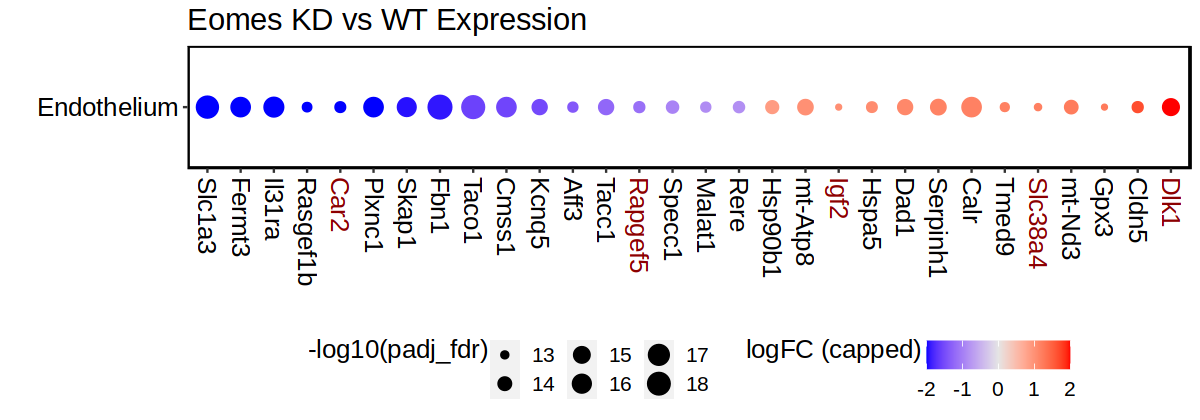

In [11]:
features = DEGs[celltype %in% args$celltypes, ] %>% 
    #.[order(-abs(logFC)),] %>% 
    .[order(padj_fdr)] %>%
     .[,head(.SD, 30), by=celltype] %>% 
    .[order(logFC)] %>% 
    .$gene %>% unique()

# # Turn dt in matrix
# DEGs.mtx = DEGs[gene %in% features & celltype %in% celltypes, c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
# DEGs.mtx[is.na(DEGs.mtx)] = 0
# DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# # Cluster genes by logFC
# order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[celltype %in% args$celltypes & gene %in% features & padj_fdr < 0.05] %>%
     # .[abs(logFC) > args$logFC_thr] %>% 
    .[, gene := factor(gene, levels = features)] %>%
    .[, celltype := factor(celltype, levels = args$celltypes)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=10, repr.plot.height=3.5)
ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    geom_hline(yintercept=seq(.5, 20, 1), alpha=0.2) + 
    geom_hline(yintercept=c(1.5, 2.5), alpha=1) + 
    scale_y_discrete(limits = args$celltypes, expand = c(0, 0.5)) + 
    ggtitle('Eomes KD vs WT Expression') + 
    theme(axis.text.x = element_text(angle=-90, hjust=0, vjust=0.5, color = ifelse(unique(to.plot[order(gene)]$gene) %in% genes_keep, 'darkred', 'black')),
         axis.text=element_text(size=15, color='black'),
         text=element_text(size=15),
            panel.border = element_rect(color='black', linewidth=1, fill = NA),
            panel.background = element_blank(),
            axis.line = element_blank(),
          legend.position = 'bottom',
          legend.title = element_text(vjust=1)
)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


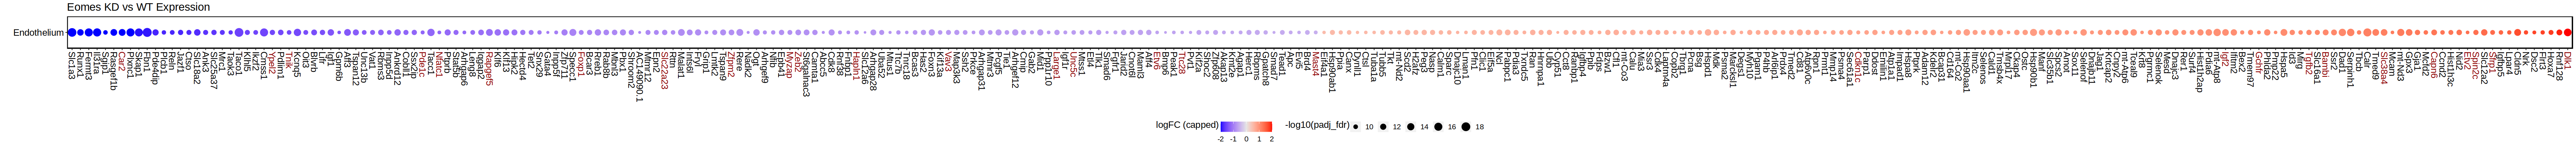

In [91]:
features = DEGs[celltype %in% args$celltypes, ] %>% 
    #.[order(-abs(logFC)),] %>% 
    .[order(padj_fdr)] %>%
     .[,head(.SD, 300), by=celltype] %>% 
    .[order(logFC)] %>% 
    .$gene %>% unique()

# # Turn dt in matrix
# DEGs.mtx = DEGs[gene %in% features & celltype %in% celltypes, c('gene',  'logFC', 'celltype')] %>% dcast(., celltype ~ gene, value.var = 'logFC')
# DEGs.mtx[is.na(DEGs.mtx)] = 0
# DEGs.mtx = DEGs.mtx %>% as.data.frame() %>% tibble::column_to_rownames('celltype')

# # Cluster genes by logFC
# order = hclust(dist(t(DEGs.mtx)))

# prepare data.table for plotting
to.plot = DEGs[celltype %in% args$celltypes & gene %in% features & padj_fdr < 0.05] %>%
     # .[abs(logFC) > args$logFC_thr] %>% 
    .[, gene := factor(gene, levels = features)] %>%
    .[, celltype := factor(celltype, levels = args$celltypes)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

options(repr.plot.width=60, repr.plot.height=3.5)
p1 = ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    geom_hline(yintercept=seq(.5, 20, 1), alpha=0.2) + 
    geom_hline(yintercept=c(1.5, 2.5), alpha=1) + 
    scale_y_discrete(limits = args$celltypes, expand = c(0, 0.5)) + 
    ggtitle('Eomes KD vs WT Expression') + 
    theme(axis.text.x = element_text(angle=-90, hjust=0, vjust=0.5, color = ifelse(unique(to.plot[order(gene)]$gene) %in% genes_keep, 'darkred', 'black')),
         axis.text=element_text(size=15, color='black'),
         text=element_text(size=15),
            panel.border = element_rect(color='black', linewidth=1, fill = NA),
            panel.background = element_blank(),
            axis.line = element_blank(),
          legend.position = 'bottom',
          legend.title = element_text(vjust=1)
)

p1

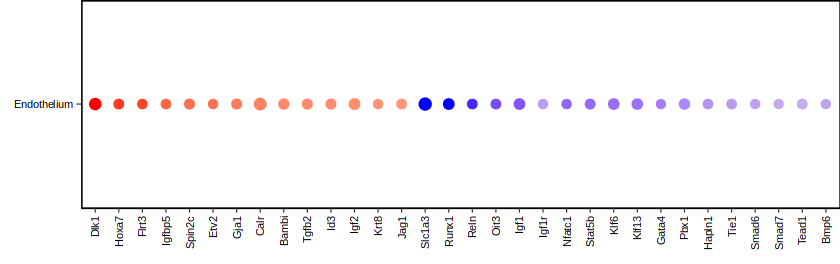

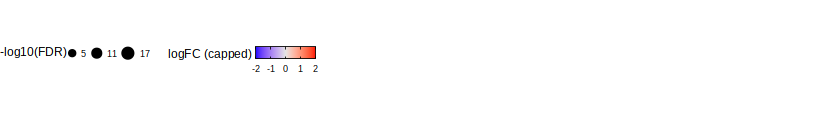

In [213]:
# Select genes to plot
genes_plot = c(
               'Dlk1', 'Hoxa7', 'Flrt3', 'Igfbp5', 'Spin2c', 'Etv2', 'Gja1', 'Calr', 'Bambi', 'Tgfb2','Id3', 'Igf2', 'Krt8', 'Jag1',
                'Slc1a3', 'Runx1', 'Reln', 'Oit3', 'Igf1', 'Igf1r', 'Nfatc1', 'Stat5b', 'Klf6', 'Klf13', 'Gata4', 'Pbx1', 'Hapln1', 'Tie1', 'Smad6', 'Smad7', 'Tead1', 'Bmp6'
              )

# prepare data.table for plotting
to.plot = DEGs[gene %in% genes_plot & padj_fdr < 0.05] %>%
     # .[abs(logFC) > args$logFC_thr] %>% 
    .[, gene := factor(gene, levels = genes_plot)] %>%
    .[, celltype := factor(celltype, levels = args$celltypes)] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]

p1 = ggplot(to.plot, aes(gene, celltype, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_size(range = c(-0.3, 2.7), limits = c(0, max(-log10(to.plot$padj_fdr))), 
                breaks = round(seq(5, max(-log10(to.plot$padj_fdr)), max(-log10(to.plot$padj_fdr))/3), -0.5),
                name = '-log10(FDR)') + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    geom_hline(yintercept=c(1.5), linewidth = 0.1) + 
    scale_y_discrete(expand = c(0, 0.5)) + 
    guides(
        size = guide_legend(order = 1),
        colour = guide_colourbar(
            barwidth = 2.5, barheight = 0.5,
            frame.colour = "black", 
            ticks.colour = "black",
            order = 2
        )
    ) + 
    theme(
        axis.text.x=element_text(angle=90,hjust=1,vjust=0.5, size=6, color = 'black'), 
        axis.text = element_text(size=6, color='black'),
        text=element_text(size=6),
        panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
        panel.background = element_blank(),
        axis.line = element_blank(),
        axis.ticks=element_line(linewidth=0.25),
        plot.margin = margin(0, 0, 0, 0),  # Adjust the margin around the plot
        legend.position = 'bottom',
        legend.title = element_text(vjust=0.85, size = 7),
        legend.margin = margin(0, 0, 0, 0),  # Adjust the margin inside the legend box
        legend.box.margin = margin(0, 0, 0, 0),  # Adjust the margin outside the legend box
        legend.key.size  = unit(1, "mm"),
        legend.key = element_blank(),
        legend.justification = "left" 
    )

options(repr.plot.width=7, repr.plot.height=2.2)
p1 + theme(legend.position = 'none')
options(repr.plot.width=7, repr.plot.height=1)
grid.newpage()                               
grid.draw(get_legend(p1))

In [29]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_DEGs.pdf'), 
       plot = p1 + theme(legend.position = 'none'),
       width = 85, 
       height = 15, 
       units = "mm")

ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_DEGs_legend.pdf'), 
       plot = as_ggplot(get_legend(p1)),
       width = 70, 
       height = 10, 
       units = "mm")

In [9]:
### Comparison of Endothelium KD vs WT LogFC with in vivo Allantois endo vs YS endo logFC

# Load Atlas metadata
atlas_meta = fread('/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation/pijuansala2019_gastrulation10x/sample_metadata_extended.txt.gz' ) %>% 
    .[celltype_extended %in% c('Allantois_endothelium', 'YS_endothelium')]

# Load Atlas SCE object
atlas.sce = load_SingleCellExperiment(io$rna.atlas.sce, normalise = TRUE, cells = atlas_meta$cell, remove_non_expressed_genes = FALSE)
atlas.sce$celltype_extended = factor(atlas_meta$celltype_extended, levels = c('Allantois_endothelium', 'YS_endothelium'))
# get gene names
gene_metadata <- fread(io$gene_metadata) %>%
  .[symbol!="" & ens_id%in%rownames(atlas.sce)] %>%
  .[!duplicated(symbol)]
rownames(atlas.sce) = gene_metadata[match(rownames(atlas.sce), ens_id), symbol]
atlas.sce = atlas.sce[!is.na(rownames(atlas.sce)),]

In [13]:
## Differential expression between allantois and YS in vivo

# Prepare pseudobulk object for EdgeR
sce_pseudobulk = aggregateAcrossCells(atlas.sce, id=paste0(atlas_meta$sample, atlas_meta$celltype_extended), BPPARAM = BPPARAM)

# Filter samples
discarded <- sce_pseudobulk$ncells < 10
sce_pseudobulk <- sce_pseudobulk[,!discarded]

# Filter genes
keep <- filterByExpr(sce_pseudobulk, group=sce_pseudobulk$celltype_extended)
sce_pseudobulk <- sce_pseudobulk[keep,]

# Convert SCE to DGEList
sce_edger <- scran::convertTo(sce_pseudobulk, type="edgeR")

# Calculate Normalisation Factors
sce_edger <- calcNormFactors(sce_edger)

# Define design matrix (with intercept)
design <- model.matrix(~sce_edger$samples$celltype_extended)

# Estimate dispersions
sce_edger  <- estimateDisp(sce_edger,design)

# Fit GLM
fit <- glmQLFit(sce_edger,design)

# Likelihood ratio test
lrt <- glmQLFTest(fit)

# Testing above logFC threshold
#lrt = glmTreat(fit, lfc=logFC_thr)

# Construct output data.frame
out <- topTags(lrt, n=nrow(lrt))$table %>% as.data.table(keep.rownames=T) %>%
  setnames(c("gene","logFC","logCPM","LR","p.value","padj_fdr")) %>%
  .[,c("logCPM","LR","p.value"):=NULL] %>%
  .[,c("padj_fdr","logFC"):=list(signif(padj_fdr,digits=3), round(logFC,3))] %>%
  .[, logFC_capped := ifelse(logFC >= 2, 2, 
                           ifelse(logFC <= -2, -2, logFC))]

fwrite(out, file.path(io$basedir, 'figures/vivo_allantois_vs_ys_endothelium_RNA.txt.gz'))

In [158]:
out = fread(file.path(io$basedir, 'figures/vivo_allantois_vs_ys_endothelium_RNA.txt.gz'))

In [159]:
genes_plot = intersect(out[abs(logFC)>0.5 & padj_fdr < 0.05, gene], DEGs$gene)

`geom_smooth()` using formula = 'y ~ x'


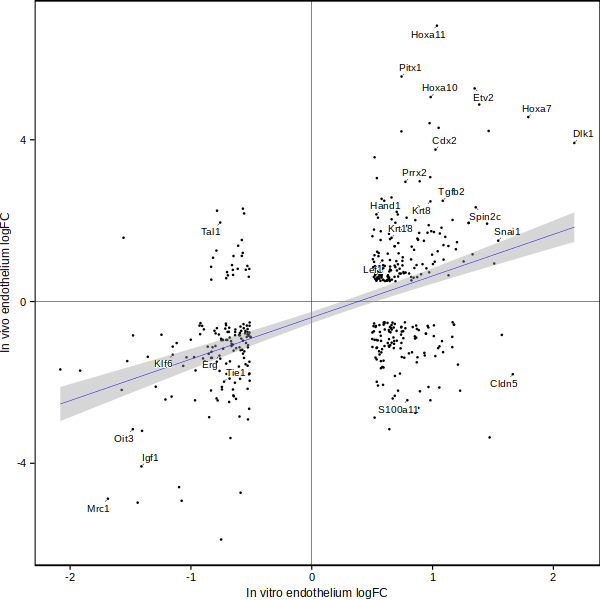

In [160]:
tmp = merge(DEGs[,c('gene', 'logFC')] %>% setnames('logFC', 'vitro'), 
            out[padj_fdr < 0.05 & abs(logFC) > 0.5][,c('gene', 'logFC')][,logFC := -1*logFC] %>% setnames('logFC', 'vivo'), by = 'gene')

gene_list = c('Dlk1', 'Hoxa7', 'Hoxa10', 'Hoxa11', 'Krt8', 'Krt18', 'Spin2c', 'Tgfb2', 'Cdx2', 'Cldn5', 'Pitx1', 'Prrx2', 'Snai1', 
             'Erg', 'Etv2', 'Hand1', 'Igf1', 'Klf6', 'Lef1', 'Mrc1', 'Oit3', 'S100a11', 'Tal1', 'Tie1')

options(repr.plot.width=5, repr.plot.height=5)
p_RNA = ggplot(tmp, aes(vitro, vivo)) +
    geom_point(size = -0.3) + 
    geom_hline(yintercept = 0, linewidth = 0.1) + geom_vline(xintercept = 0, linewidth = 0.1) + 
    geom_smooth(method = 'lm', color = '#1100ff', linewidth = 0.1) + 
    ggrepel::geom_text_repel(data = tmp[gene %in% gene_list], aes(label = gene), 
                          size = 6 * 0.35,
                          box.padding = 0.15,
                          bg.color='white', 
                          bg.r = 0.1,
                          min.segment.length = 0,
                          segment.size = unit(0.1, 'mm')) + 
    xlab('In vitro endothelium logFC') + ylab('In vivo endothelium logFC') + 
    # coord_fixed(ratio = 1) + 
    theme(
        axis.text = element_text(size = 6, color='black'),
        axis.title = element_text(size = 7),
        text=element_text(size=6),
        panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
        panel.background = element_blank(),
        axis.line = element_blank(),
        axis.ticks = element_line(linewidth=0.25, color = 'black'),
        plot.margin = margin(0, 0, 0, 0),  # Adjust the margin around the plot
    )
p_RNA

In [30]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_invivo_comparison_RNA.pdf'), 
       plot = p_RNA,
       width = 60, 
       height = 60, 
       units = "mm")

`geom_smooth()` using formula = 'y ~ x'


In [161]:
tmp = rbind(DEGs[gene %in% genes_plot, c('gene', 'logFC', 'padj_fdr')][,test := 'KD vs WT \n (in vitro)'] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))],
            out[gene %in%genes_plot, c('gene', 'logFC', 'padj_fdr')][,test := 'Allantois vs YS \n (in vivo)'][,logFC := logFC * -1] %>% 
    .[, logFC_capped := ifelse(logFC >= 2, 2, 
                               ifelse(logFC <= -2, -2, logFC))]) %>% 
    .[,test := factor(test, levels = c('KD vs WT \n (in vitro)', 'Allantois vs YS \n (in vivo)'))]

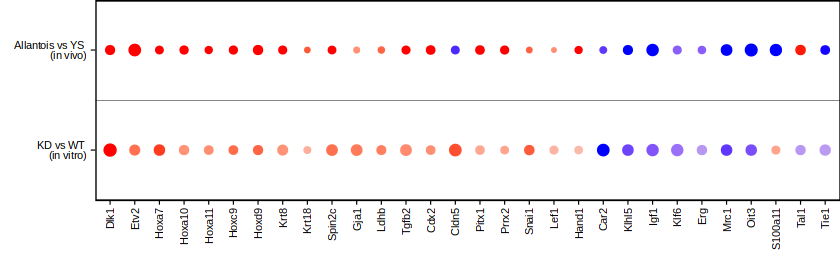

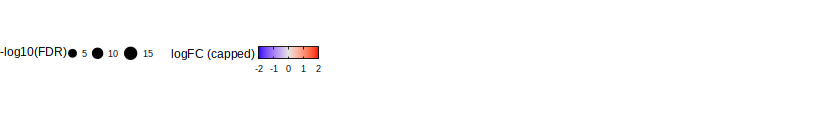

In [163]:

gene_list = c('Dlk1','Etv2', 'Hoxa7', 'Hoxa10', 'Hoxa11', 'Hoxc9', 'Hoxd9', 'Krt8', 'Krt18', 'Spin2c', 'Gja1', 'Ldhb', 'Tgfb2', 'Cdx2', 'Cldn5', 'Pitx1', 'Prrx2', 'Snai1', 
             'Lef1', 'Hand1', 'Car2', 'Klhl5',  'Igf1', 'Klf6','Erg', 'Mrc1', 'Oit3', 'S100a11', 'Tal1', 'Tie1')
to.plot = tmp[gene %in% gene_list] %>% .[,gene := factor(gene, levels = gene_list)]
p1_wAtlas = ggplot(to.plot, aes(gene, test, size=-log10(padj_fdr), col=logFC_capped)) + 
    geom_point() + 
    scale_size(range = c(-0.3, 2.7), limits = c(0, max(-log10(to.plot$padj_fdr))), 
                breaks = round(seq(5, max(-log10(to.plot$padj_fdr)), max(-log10(to.plot$padj_fdr))/3), -0.5),
                name = '-log10(FDR)') + 
    scale_color_gradient2(low='blue', mid = 'gray90', high='red', name='logFC (capped)') + 
    xlab('') + ylab('') +
    geom_hline(yintercept=c(1.5), linewidth = 0.1) + 
    scale_y_discrete(expand = c(0, 0.5)) + 
    guides(
        size = guide_legend(order = 1),
        colour = guide_colourbar(
            barwidth = 2.5, barheight = 0.5,
            frame.colour = "black", 
            ticks.colour = "black",
            order = 2
        )
    ) + 
    theme(
        axis.text.x=element_text(angle=90,hjust=1,vjust=0.5, size=6, color = 'black'), 
        axis.text = element_text(size=6, color='black'),
        text=element_text(size=6),
        panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
        panel.background = element_blank(),
        axis.line = element_blank(),
        axis.ticks=element_line(linewidth=0.25, color = 'black'),
        plot.margin = margin(0, 0, 0, 0),  # Adjust the margin around the plot
        legend.position = 'bottom',
        legend.title = element_text(vjust=0.85, size = 7),
        legend.margin = margin(0, 0, 0, 0),  # Adjust the margin inside the legend box
        legend.box.margin = margin(0, 0, 0, 0),  # Adjust the margin outside the legend box
        legend.key.size  = unit(1, "mm"),
        legend.key = element_blank(),
        legend.justification = "left" 
    )

options(repr.plot.width=7, repr.plot.height=2.2)
p1_wAtlas + theme(legend.position = 'none')
options(repr.plot.width=7, repr.plot.height=1)
grid.newpage()                               
grid.draw(get_legend(p1_wAtlas))

In [164]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_DEGs_wAtlas.pdf'), 
       plot = p1_wAtlas + theme(legend.position = 'none'),
       width = 85, 
       height = 25, 
       units = "mm")

ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_DEGs_wAtlas_legend.pdf'), 
       plot = as_ggplot(get_legend(p1_wAtlas)),
       width = 70, 
       height = 10, 
       units = "mm")

'select()' returned 1:many mapping between keys and columns



GOALL,Term,Ont,N,DE,P.DE,FDR,enrichment,genes
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GO:0045048,protein insertion into ER membrane,BP,22,9,5.095595e-09,3.229139e-07,600.3409,"Mmgt1, Ubl4a, Sgta, Sec61a1, Emc6, Ccdc47, Emc4, Emc10, Emc7"
GO:0006268,DNA unwinding involved in DNA replication,BP,21,5,1.747425e-04,4.321712e-03,366.0431,"Mcm3, Mcm2, Mcm5, Mcm7, Gins2"
GO:0003181,atrioventricular valve morphogenesis,BP,24,6,2.848147e-05,9.087457e-04,336.3021,"Efna1, Ccn1, Sox4, Tgfb2, Twist1, Dchs1"
GO:0042026,protein refolding,BP,24,6,2.848147e-05,9.087457e-04,336.3021,"B2m, Hspa5, Hspa8, Hspd1, Hsp90aa1, Pdcl"
GO:0008535,respiratory chain complex IV assembly,BP,24,6,3.664750e-05,1.123840e-03,336.3021,"Sco2, mt-Co3, Surf1, Cox14, Timm21, Cox19"
GO:0070199,establishment of protein localization to chromosome,BP,24,6,7.290928e-05,2.007155e-03,336.3021,"Cct5, Cct6a, Cct7, Cct8, Ruvbl2, Pih1d1"
GO:0071353,cellular response to interleukin-4,BP,29,8,7.508025e-07,3.335167e-05,307.1106,"Cdk4, Fasn, Hspa5, Hsp90ab1, Lef1, Mcm2, Tuba1b, Xbp1"
GO:0030970,"retrograde protein transport, ER to cytosol",BP,26,6,4.658949e-05,1.385992e-03,286.5533,"Selenos, Aup1, Bcap31, Sec61b, Derl1, Syvn1"
GO:1903513,endoplasmic reticulum to cytosol transport,BP,26,6,4.658949e-05,1.385992e-03,286.5533,"Selenos, Aup1, Bcap31, Sec61b, Derl1, Syvn1"


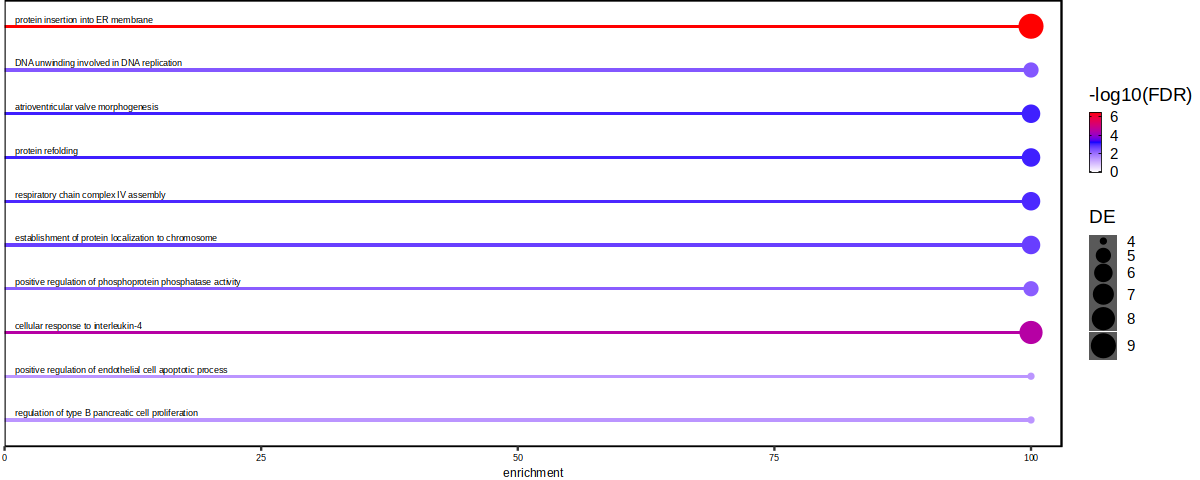

In [12]:
genes = DEGs[logFC>0, gene]
tmp = do_GO(genes, background = rownames(rna.sce))
head(tmp[[1]] %>% .[FDR < 0.005] %>% .[Ont == 'BP'] %>% .[N > 20 & N < 1000 & DE > 3 & enrichment > 3] %>% .[order(-enrichment)], 10)
tmp[[2]]

In [24]:
head(DEGs)

gene,logFC,padj_fdr,mean_groupA,mean_groupB,cdr_groupA,cdr_groupB,celltype
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Fbn1,-1.917,2.04e-19,8.66,6.73,0.82,0.57,Endothelium
Taco1,-1.591,7.76e-19,9.92,8.32,0.97,0.95,Endothelium
Slc1a3,-4.979,2.25e-18,6.69,2.00,0.31,0.03,Endothelium
Il31ra,-2.474,3.80e-17,7.90,5.43,0.70,0.41,Endothelium
Fermt3,-3.037,6.21e-17,6.35,3.41,0.52,0.13,Endothelium
Plxnc1,-2.026,6.21e-17,7.30,5.28,0.63,0.33,Endothelium


In [18]:
genes = DEGs[logFC<0, gene]
tmp = do_GO(genes, background = rownames(rna.sce))
head(tmp[[1]] %>% .[enrichment>50] %>% .[Ont == 'BP'] %>% .[N > 20 & N < 1000 & DE > 3 & enrichment > 3] %>% .[order(FDR)], 10)

'select()' returned 1:many mapping between keys and columns



GOALL,Term,Ont,N,DE,P.DE,FDR,enrichment,genes
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GO:0046854,phosphatidylinositol phosphate biosynthetic process,BP,50,11,2.753487e-08,1.662046e-06,142.05400,"Ttc7b, Pik3r3, Pip5k1c, Pip4k2a, Pi4ka, Pik3c2b, Ip6k1, Socs4, Pik3cb, Pik3r4, Pi4k2a"
GO:0003179,heart valve morphogenesis,BP,47,9,8.924270e-07,4.409514e-05,131.53689,"Gata4, Smad6, Mdm4, Nfatc1, Rb1, Tgfb1, Tie1, Zfpm1, Zfpm2"
GO:0048009,insulin-like growth factor receptor signaling pathway,BP,36,8,1.096020e-06,5.369089e-05,199.29012,"Igf1, Igf1r, Igfbp2, Inppl1, Plcb1, Atxn1, Atxn7, Gigyf1"
GO:0060043,regulation of cardiac muscle cell proliferation,BP,49,9,2.179762e-06,1.001333e-04,121.01833,"Foxp1, Apc, Fgfr1, Gata4, Jarid2, Meis1, Ncam1, Nrg1, Zfpm2"
GO:0014855,striated muscle cell proliferation,BP,82,11,3.264871e-06,1.446813e-04,52.81603,"Foxp1, Apc, Fgfr1, Gata4, Jak2, Jarid2, Meis1, Ncam1, Stat3, Nrg1, Zfpm2"
GO:0046856,phosphatidylinositol dephosphorylation,BP,30,7,3.680290e-06,1.609828e-04,251.10556,"Inpp5f, Inpp5d, Inppl1, Inpp4b, Mtmr12, Mtmr3, Sacm1l"
GO:0098751,bone cell development,BP,42,8,4.571578e-06,1.954841e-04,146.41723,"Foxp1, Fbn1, Meis1, Pip4k2a, Tal1, Tjp2, Zfpm1, Wasf2"
GO:0003170,heart valve development,BP,58,9,5.595155e-06,2.352948e-04,86.37485,"Gata4, Smad6, Mdm4, Nfatc1, Rb1, Tgfb1, Tie1, Zfpm1, Zfpm2"
GO:0003180,aortic valve morphogenesis,BP,22,6,6.976466e-06,2.875687e-04,400.22727,"Gata4, Smad6, Nfatc1, Rb1, Tgfb1, Tie1"


'select()' returned 1:many mapping between keys and columns



GOALL,Term,Ont,N,DE,P.DE,FDR,enrichment,genes
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GO:0003180,aortic valve morphogenesis,BP,22,6,6.976466e-06,0.0002875687,400.2273,"Gata4, Smad6, Nfatc1, Rb1, Tgfb1, Tie1"
GO:0060216,definitive hemopoiesis,BP,25,6,1.563324e-05,0.0005980628,309.9360,"Bcr, Runx1, Lyl1, Meis1, Tal1, Zfpm1"
GO:0099149,regulation of postsynaptic neurotransmitter receptor internalization,BP,23,5,1.368125e-04,0.0041020454,305.1512,"Pip5k1c, Ppp3r1, Nrg1, Iqsec1, Ophn1"
GO:0032332,positive regulation of chondrocyte differentiation,BP,21,4,1.122304e-03,0.0239728677,292.8345,"Pkdcc, Bmp6, Smad3, Smad7"
GO:0070886,positive regulation of calcineurin-NFAT signaling cascade,BP,21,4,1.122304e-03,0.0239728677,292.8345,"Camta1, Igf1, Ppp3r1, Nrg1"
GO:0106058,positive regulation of calcineurin-mediated signaling,BP,21,4,1.122304e-03,0.0239728677,292.8345,"Camta1, Igf1, Ppp3r1, Nrg1"
GO:0045722,positive regulation of gluconeogenesis,BP,21,4,1.122304e-03,0.0239728677,292.8345,"Kat2b, Tcf7l2, Foxo1, Supt20"
GO:0035020,regulation of Rac protein signal transduction,BP,26,6,1.993742e-05,0.0007514140,286.5533,"Arap3, Ogt, Dnm2, Arhgap17, Pik3cb, Ssx2ip"
GO:0003181,atrioventricular valve morphogenesis,BP,24,5,1.696287e-04,0.0049314881,280.2517,"Gata4, Smad6, Mdm4, Zfpm1, Zfpm2"


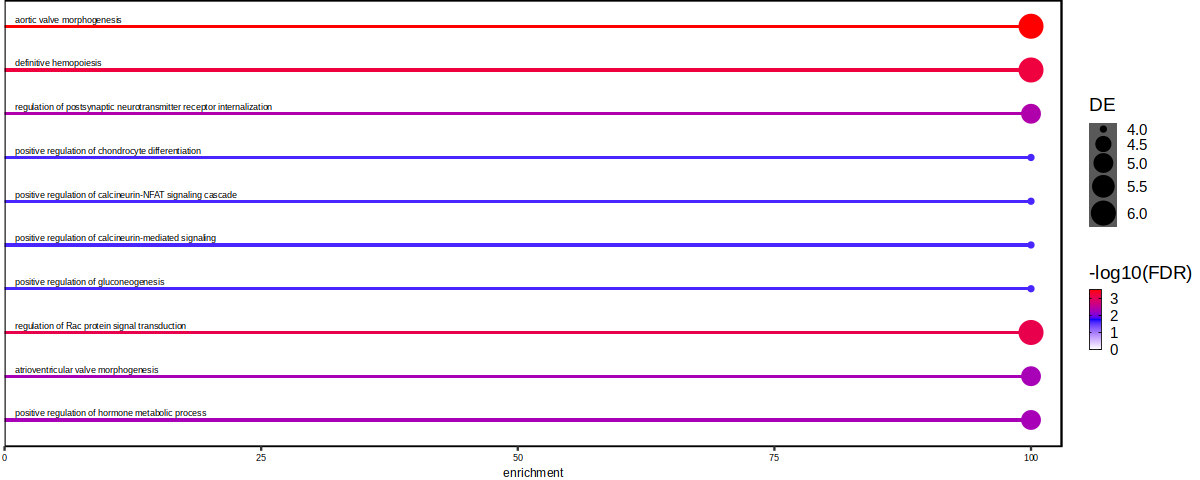

In [11]:
genes = DEGs[logFC<0, gene]
tmp = do_GO(genes, background = rownames(rna.sce))
head(tmp[[1]] %>% .[FDR < 0.05] %>% .[Ont == 'BP'] %>% .[N > 20 & N < 1000 & DE > 3 & enrichment > 3] %>% .[order(-enrichment)], 10)
tmp[[2]]

In [35]:
args$homer = sprintf('%s/promoters/', args$outdir)
dir.create(args$homer, recursive=TRUE, showWarnings =FALSE)

tmp = as.data.table(ArchRProject@geneAnnotation$genes) %>% 
    .[, TSS := ifelse(strand == '+', start, end)] %>% 
    .[, `:=`(promoter_start = TSS - 0,
             promoter_end = TSS + 1)]
bed = tmp[,c('seqnames', 'promoter_start', 'promoter_end')] %>% setnames(c('chr', 'start', 'end'))
fwrite(bed, sprintf('%s/background.bed', args$homer) , col.names=F, sep='\t')

In [36]:
# Up
features_up = DEGs[celltype %in% args$celltypes  & padj_fdr < 0.05 & logFC > 0.5, ] %>%
    .[order(-logFC)]

tmp = as.data.table(ArchRProject@geneAnnotation$genes) %>% 
    .[symbol %in% features_up$gene] %>%
    .[, TSS := ifelse(strand == '+', start, end)] %>% 
    .[, `:=`(promoter_start = TSS,
             promoter_end = TSS+1)]
bed = tmp[,c('seqnames', 'promoter_start', 'promoter_end')] %>% setnames(c('chr', 'start', 'end'))

fwrite(bed, sprintf('%s/up.bed', args$homer) , col.names=F, sep='\t')

# Down
features_down = DEGs[celltype %in% args$celltypes  & padj_fdr < 0.05 & logFC <= -0.5, ] %>%
    .[order(-logFC)]

tmp = as.data.table(ArchRProject@geneAnnotation$genes) %>% 
    .[symbol %in% features_down$gene] %>%
    .[, TSS := ifelse(strand == '+', start, end)] %>% 
    .[, `:=`(promoter_start = TSS - 0,
             promoter_end = TSS + 1)]
bed = tmp[,c('seqnames', 'promoter_start', 'promoter_end')] %>% setnames(c('chr', 'start', 'end'))

fwrite(bed, sprintf('%s/down.bed', args$homer) , col.names=F, sep='\t')

# Motif search using Homer
files = gsub('.bed', '', list.files(args$homer, pattern = '.bed'))
mclapply(files[2:3], function(x){
    cmd = sprintf('/rds/project/rds-SDzz0CATGms/users/bt392/software/homer/bin/findMotifsGenome.pl %s/%s.bed mm10 %s/%s -size 75 -bg %s/background.bed -S 5 -len 8,10,12  -p 24', 
                       args$homer, x,
                         args$homer, x,
                          args$homer)
    system(cmd)
},mc.cores=12)

[[1]]
[1] 0

[[2]]
[1] 0

### ATAC

In [89]:
# matches <- getMatches(ArchRProject, 'Motif_cisbp')
# rownames(matches) = rownames(atac.sce)

io$multiome = '/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/results/multiome_atlas/'
silico_chip = readRDS(file.path(io$multiome, 'vitro_peaks_silicoChIP_cisbp.rds'))
# jaspar_silico_chip = readRDS(file.path(io$multiome, 'vitro_peaks_silicoChIP_jaspar2020.rds'))
assay(silico_chip, 'matches') = assay(silico_chip, 'VirtualChipScores') > 0.20
assay(silico_chip, 'motifScores') = NULL
assay(silico_chip, 'motifMatches') = NULL
assay(silico_chip, 'motifCounts') = NULL
assay(silico_chip, 'VirtualChipScores') = NULL
matches = silico_chip

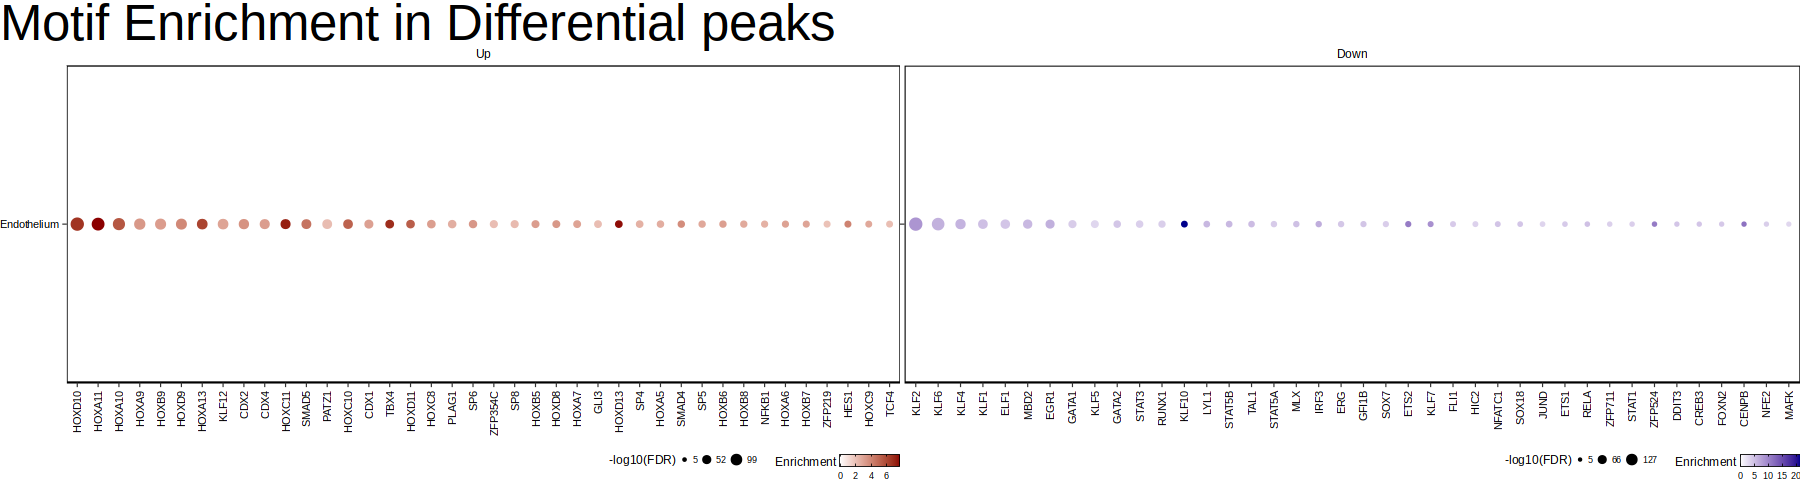

In [226]:
ntop = 40
options(repr.plot.width=30, repr.plot.height=4)

up = lapply(args$celltypes, function(x){
    tmp = as.data.table(ArchR:::.computeEnrichment(matches, DARs[celltype == x & logFC > 0.5 & padj_fdr < 5e-2, peak], seq_len(nrow(matches)))) %>%
            .[,feature := str_split(feature, '_') %>% map_chr(1)] %>% 
            .[mlog10Padj > -log10(0.05)] %>% 
            .[,celltype := x]
    return(tmp)
}) %>% rbindlist() %>% 
    .[, celltype := factor(celltype, levels = names(opts$celltype_v2.colors))]
p1 = plot_enr_heatmap(up, ntop = ntop, title = 'Up', color = 'darkred')

down = lapply(args$celltypes, function(x){
    tmp = as.data.table(ArchR:::.computeEnrichment(matches, DARs[celltype == x & logFC <= -0.5 & padj_fdr < 5e-2, peak], seq_len(nrow(matches)))) %>%
            .[,feature := str_split(feature, '_') %>% map_chr(1)] %>% 
            .[mlog10Padj > -log10(0.05)] %>% 
            .[,celltype := x]
    return(tmp)
}) %>% rbindlist() %>% 
    .[, celltype := factor(celltype, levels = names(opts$celltype_v2.colors))]
p2 = plot_enr_heatmap(down, ntop = ntop, title = 'Down')

options(repr.plot.width=15, repr.plot.height=4)

ggarrange(p1, p2 + theme(axis.text.y = element_blank()), align = 'h', widths = c(1, 1), nrow = 1) + 
    ggtitle('Motif Enrichment in Differential peaks') + 
    theme(plot.title = element_text(size = 30, hjust = 0),
            plot.title.position = "plot",
            plot.margin = unit(c(0,0, 0, 0), 'lines'))

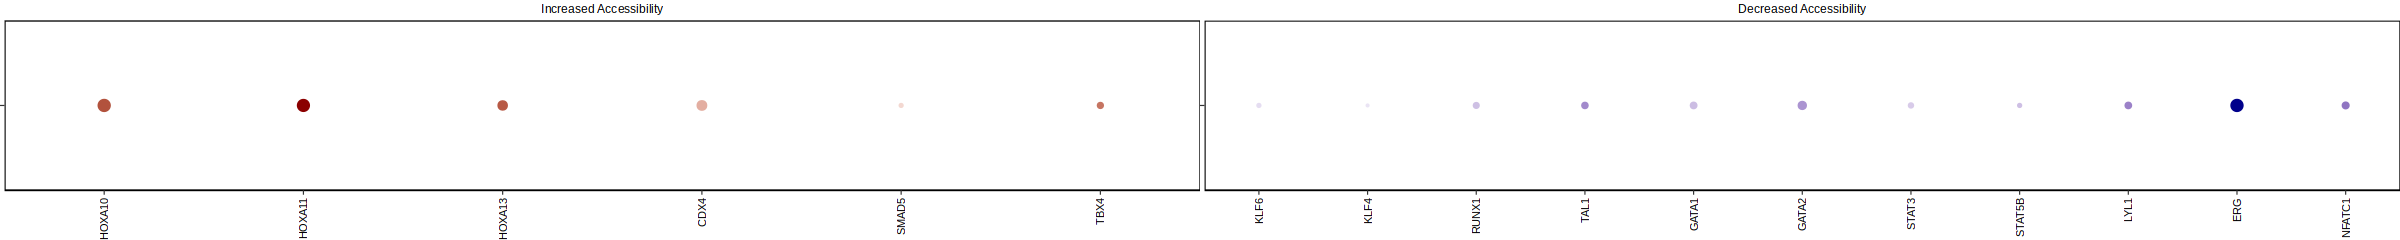

In [147]:
plot_enr_heatmap = function(motif_enrichment, ntop=25, TFs = NULL, title = 'Motifs in marker peaks', subtitle = NULL, color = 'darkblue') {

    if(!is.null(TFs)){
        keep_tfs = TFs
    }else{
        keep_tfs = motif_enrichment %>% .[,variable:=factor(celltype, levels= names(opts$celltype_v2.colors))] %>% .[order(c(celltype, -mlog10Padj))] %>% .[, head(.SD, ntop),  by=celltype] %>% .$feature   
    }
    
    enriched.dt = motif_enrichment[feature %in% keep_tfs] %>% .[order( -mlog10Padj)] %>% 
        #.[,TF:=strsplit(TF, '_') %>% map_chr(1)] %>%
         .[,feature:=factor(feature, levels=unique(keep_tfs))] %>%
        .[,variable:=factor(celltype, levels=names(opts$celltype_v2.colors))]
    
    pretty_breaks <- function(n = 3) {
      function(x) pretty(x, n = n)
    }
    
    p = ggplot(enriched.dt, aes(feature, celltype, color = Enrichment, size=mlog10Padj)) + 
        geom_point() +
        scale_color_gradient2(low='white', mid = 'white', high=color, name='Enrichment', 
                              midpoint = 0, limits = c(0, max(enriched.dt$Enrichment))) + # , breaks = c(0,100), labels = c('Min', 'Max')
        scale_size(range = c(-0.3, 2.7), 
                   limits = c(0, max(enriched.dt$mlog10Padj)), 
                   breaks = round(seq(5, max(enriched.dt$mlog10Padj), max(enriched.dt$mlog10Padj)/3), -0.5),
                   name = '-log10(FDR)') + 
        scale_y_discrete(expand = c(0, 0.5)) + 
        scale_x_discrete(expand = c(0, 0.5)) + 
        geom_hline(yintercept=c(1.5), linewidth = 0.1) + 
        guides(
            size = guide_legend(order = 1),
            colour = guide_colourbar(
                barwidth = 2.5, barheight = 0.5,
                frame.colour = "black", 
                ticks.colour = "black",
                order = 2
            )
        ) + 
        labs(title = title, caption = subtitle) + 
        theme(
            axis.title = element_blank(),
            axis.text.x = element_text(angle=90,hjust=1,vjust=0.5, size=6, color = 'black'), 
            axis.text = element_text(size=6, color='black'),
            text=element_text(size=6),
            plot.margin = margin(0, 0, 0, 0),  # Adjust the margin around the plot
            plot.title = element_text(size=7, face='plain', hjust=0.5, vjust = -0.5),
            panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
            panel.background = element_blank(),
            axis.line = element_blank(),
            axis.ticks=element_line(linewidth=0.25),
            legend.position = 'bottom',
            legend.title = element_text(vjust=0.85, size = 7),
            legend.margin = margin(0, 0, 0, 0),  # Adjust the margin inside the legend box
            legend.box.margin = margin(0, 0, 0, 0),  # Adjust the margin outside the legend box
            legend.key.size  = unit(1, "mm"),
            legend.key = element_blank(),
            legend.justification = "right" 
        )
    
p
    return(p)
}

p2 = plot_enr_heatmap(up, TFs = c('HOXA10', 'HOXA11', 'HOXA13', 'CDX4', 'SMAD5', 'TBX4'), title = 'Increased Accessibility', color = 'darkred')
p3 = plot_enr_heatmap(down, TFs = c('KLF6', 'KLF4', 'RUNX1', 'TAL1', 'GATA1', 'GATA2', 'STAT3', 'STAT5B', 'LYL1', 'ERG', 'NFATC1'), title = 'Decreased Accessibility')

options(repr.plot.height=2, repr.plot.width=20)
ggarrange(p2 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          NULL, 
          p3 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          align = 'h', widths = c(1, -0.0, 1), nrow = 1)

In [35]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_motifs.pdf'), 
       plot = ggarrange(p2 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          NULL, 
          p3 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          align = 'h', widths = c(0.7, -0.0, 1), nrow = 1) + 
    theme(plot.margin = unit(c(0,0, 0, 0), 'lines')),
       width = 60, 
       height = 20, 
       units = "mm")

ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_motifs_legend.pdf'), 
       plot = ggarrange(as_ggplot(get_legend(p2)), 
                    NULL,
                    as_ggplot(get_legend(p3)), ncol = 1, heights = c(1,-0.75,1)),
       width = 70, 
       height = 30, 
       units = "mm")

In [40]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_combined.pdf'), 
       plot = ggarrange(
          p1 + theme(legend.position = 'none'), 
          NULL,
          p2 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          NULL, 
          p3 + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          align = 'h', widths = c(3, 0.01, 0.6, 0.01, 1), ncol = 5) + 
    theme(plot.margin = unit(c(0,0, 0, 0), 'lines')),
       width = 150, 
       height = 22, 
       units = "mm")

In [16]:
### Differential expression between allantois and YS in vivo for ATAC

# Load in vivo ATAC
# io = list()
io$atlas_basedir = '/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/'

## Single-cell
io$RNA_sce = file.path(io$atlas_basedir,"data/processed/rna/SingleCellExperiment.rds")
io$meta = file.path(io$atlas_basedir,"results/atac/archR/qc/sample_metadata_after_qc.txt.gz")

# ArchR vitro
io$archrvitro = file.path("/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR")
# ArchR vivo
io$archrvivo = file.path(io$atlas_basedir,"data/processed/atac/archR")

meta = fread(io$meta)[pass_rnaQC == T & pass_atacQC == T & doublet_call == F & !sample %in% c('E8.5_CRISPR_T_KO', 'E8.5_CRISPR_T_WT')]

# Load ArchR projects
archrvivo = suppressMessages(loadArchRProject(io$archrvivo)[meta$cell])
archrvitro = suppressMessages(loadArchRProject(io$archrvitro))

# Create in vivo count matrix for the peaks from the in vitro multiome
addArchRThreads(10)
archrvivo = addFeatureMatrix(
              input = archrvivo,
              features = getPeakSet(archrvitro),
              matrixName = "vitroPeakMatrix",
              ceiling = 4,
              binarize = FALSE,
              verbose = TRUE,
              threads = getArchRThreads(),
              parallelParam = NULL,
              force = TRUE,
              logFile = createLogFile("vitroPeakMatrix")
            )

# retrieve count matrix
addArchRThreads(5)
atac.sce = getMatrixFromProject(archrvivo, useMatrix = 'vitroPeakMatrix')

Setting default number of Parallel threads to 10.

ArchR logging to : ArchRLogs/ArchR-vitroPeakMatrix-2d073e6ca37458-Date-2024-07-06_Time-15-09-16.log
If there is an issue, please report to github with logFile!

2024-07-06 15:09:17 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-vitroPeakMatrix-2d073e6ca37458-Date-2024-07-06_Time-15-09-16.log

Setting default number of Parallel threads to 5.

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-2d073e98a741b-Date-2024-07-06_Time-15-13-34.log
If there is an issue, please report to github with logFile!

2024-07-06 15:14:36 : Organizing colData, 1.047 mins elapsed.

2024-07-06 15:14:37 : Organizing rowData, 1.056 mins elapsed.

2024-07-06 15:14:37 : Organizing rowRanges, 1.056 mins elapsed.

2024-07-06 15:14:37 : Organizing Assays (1 of 1), 1.056 mins elapsed.

2024-07-06 15:15:23 : Constructing SummarizedExperiment, 1.825 mins elapsed.

2024-07-06 15:16:34 : Finished Matrix Creation, 3.

In [17]:
# In vivo multiome endothelium annotations
endothelium_annotation = as.data.table(
    colData(
        readRDS('/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation_multiome/results/endothelium/endothelium_sce.rds')),
    keep.rownames = T) %>% 
    setnames('rn', 'cell') %>% 
    .[seurat_cluster %in% c('YS_endothelium','Allantois_endothelium')] %>% 
    .[cell %in% colnames(atac.sce)]

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


In [18]:
atac.sce = atac.sce[,endothelium_annotation$cell]
atac.sce$celltype = endothelium_annotation$seurat_cluster

In [19]:
# convert to proper SCE object
count.mtx = assay(atac.sce, 'vitroPeakMatrix')

atac.sce2 = SingleCellExperiment(list(counts = count.mtx))
rownames(atac.sce2) = paste0(seqnames(getPeakSet(archrvitro)), ':', ranges(getPeakSet(archrvitro)))
atac.sce2$celltype = endothelium_annotation$celltype

In [20]:
## Differential expression between allantois and YS in vivo

# Prepare pseudobulk object for EdgeR
sce_pseudobulk = aggregateAcrossCells(atac.sce2, id=paste0(endothelium_annotation$sample, endothelium_annotation$celltype), BPPARAM = BPPARAM)

# Filter samples
discarded <- sce_pseudobulk$ncells < 10
sce_pseudobulk <- sce_pseudobulk[,!discarded]

# Filter genes
keep <- filterByExpr(sce_pseudobulk, group=sce_pseudobulk$celltype, min.count = 5, min.total.count = 10)
sce_pseudobulk <- sce_pseudobulk[keep,]

In [21]:
# Convert SCE to DGEList
sce_edger <- scran::convertTo(sce_pseudobulk, type="edgeR")

# Calculate Normalisation Factors
sce_edger <- calcNormFactors(sce_edger)

# Define design matrix (with intercept)
design <- model.matrix(~sce_edger$samples$celltype)

# Estimate dispersions
sce_edger  <- estimateDisp(sce_edger,design)

# Fit GLM
fit <- glmQLFit(sce_edger,design)

# Likelihood ratio test
lrt <- glmQLFTest(fit)

# Testing above logFC threshold
#lrt = glmTreat(fit, lfc=logFC_thr)

# Construct output data.frame
out <- topTags(lrt, n=nrow(lrt))$table %>% as.data.table(keep.rownames=T) %>%
  setnames(c("gene","logFC","logCPM","LR","p.value","padj_fdr")) %>%
  .[,c("logCPM","LR","p.value"):=NULL] %>%
  .[,c("padj_fdr","logFC"):=list(signif(padj_fdr,digits=3), round(logFC,3))] %>%
  .[, logFC_capped := ifelse(logFC >= 2, 2, 
                           ifelse(logFC <= -2, -2, logFC))]

fwrite(out, file.path(io$basedir, 'figures/vivo_allantois_vs_ys_endothelium_ATAC.txt.gz'))

In [101]:
out = fread(file.path(io$basedir, 'figures/vivo_allantois_vs_ys_endothelium_ATAC.txt.gz'))

In [102]:
out = out[,logFC := -1*logFC] # Flip sign to align with in vitro

`geom_smooth()` using formula = 'y ~ x'


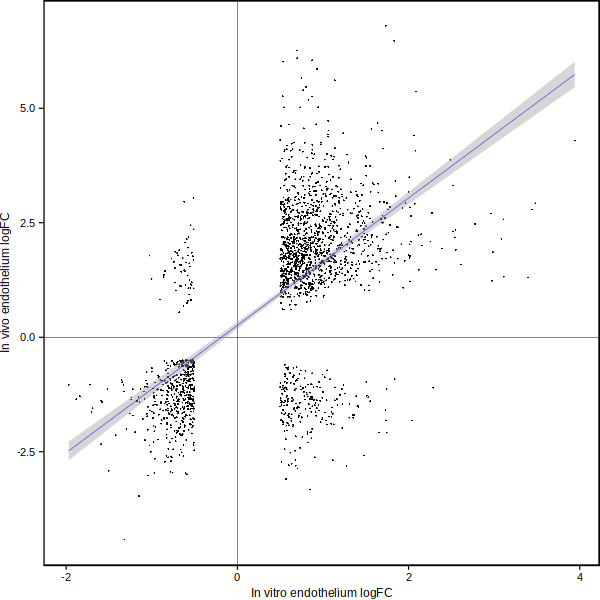

In [61]:
tmp = merge(DARs[,c('peak', 'logFC')] %>% setnames('logFC', 'vitro'), 
            out[padj_fdr < 0.05 & abs(logFC) > 0.5][,c('gene', 'logFC')] %>% setnames('logFC', 'vivo') %>% setnames('gene', 'peak'), by = 'peak')

options(repr.plot.width=5, repr.plot.height=5)
p_ATAC = ggplot(tmp, aes(vitro, vivo)) +
    ggrastr::rasterize(geom_point(size = -0.3), dpi = 900) + 
     # ggrepel::geom_text_repel(data = tmp[gene %in% gene_list], aes(label = gene), 
     #                          size = 6 * 0.35,
     #                          bg.color='white', 
     #                          bg.r = 0.1,) + 
    geom_hline(yintercept = 0, linewidth = 0.1) + geom_vline(xintercept = 0, linewidth = 0.1) + 
    geom_smooth(method = 'lm', color = '#1100ff', linewidth = 0.1) + 
    xlab('In vitro endothelium logFC') + ylab('In vivo endothelium logFC') + 
   # coord_fixed(ratio = 0.25) + 
    theme(
        axis.text = element_text(size = 6, color='black'),
        axis.title = element_text(size = 7),
        text=element_text(size=6),
        panel.border = element_rect(color='black', linewidth=0.5, fill = NA),
        panel.background = element_blank(),
        axis.line = element_blank(),
        axis.ticks = element_line(linewidth=0.25, color = 'black'),
        plot.margin = margin(0, 0, 0, 0),  # Adjust the margin around the plot
    )
p_ATAC

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


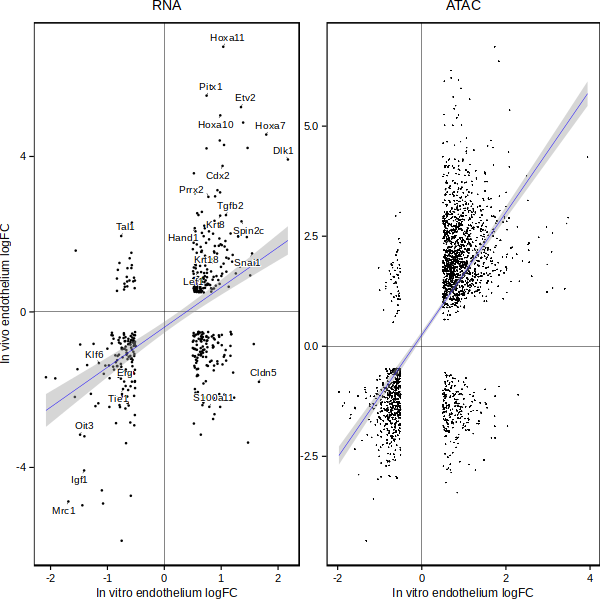

In [63]:
p_vivo_vitro = ggarrange(p_RNA + ggtitle('RNA') + theme(plot.title = element_text(size = 8, hjust = 0.5)), 
          p_ATAC + ggtitle('ATAC') + theme(plot.title = element_text(size = 8, hjust = 0.5),
                                          axis.title.y = element_blank()), align = "h")
p_vivo_vitro

ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_invivo_comparison.pdf'), 
       plot = p_vivo_vitro,
       width = 110, 
       height = 50, 
       units = "mm")

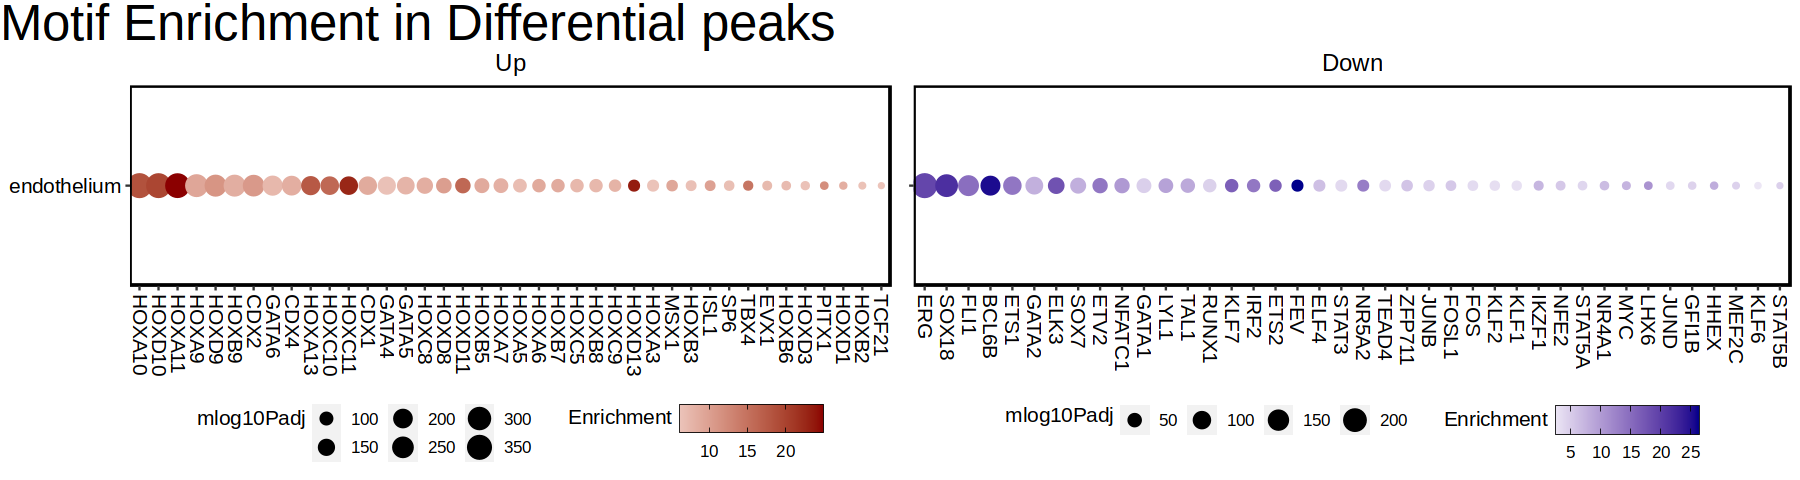

In [103]:
ntop = 40
options(repr.plot.width=30, repr.plot.height=4)
x = 'endothelium'
    up = as.data.table(ArchR:::.computeEnrichment(matches, out[logFC > 0.5 & padj_fdr < 5e-2, gene], seq_len(nrow(matches)))) %>%
            .[,feature := str_split(feature, '_') %>% map_chr(1)] %>% 
            .[mlog10Padj > -log10(0.05)] %>% 
            .[,celltype := x]
p2_vivo = plot_enr_heatmap(up, ntop = ntop, title = 'Up', color = 'darkred')

    down = as.data.table(ArchR:::.computeEnrichment(matches, out[logFC <= -0.5 & padj_fdr < 5e-2, gene], seq_len(nrow(matches)))) %>%
            .[,feature := str_split(feature, '_') %>% map_chr(1)] %>% 
            .[mlog10Padj > -log10(0.05)] %>% 
            .[,celltype := x]

p3_vivo = plot_enr_heatmap(down, ntop = ntop, title = 'Down')

options(repr.plot.width=15, repr.plot.height=4)

ggarrange(p2_vivo, p3_vivo + theme(axis.text.y = element_blank()), align = 'h', widths = c(1, 1), nrow = 1) + 
    ggtitle('Motif Enrichment in Differential peaks') + 
    theme(plot.title = element_text(size = 30, hjust = 0),
            plot.title.position = "plot",
            plot.margin = unit(c(0,0, 0, 0), 'lines'))

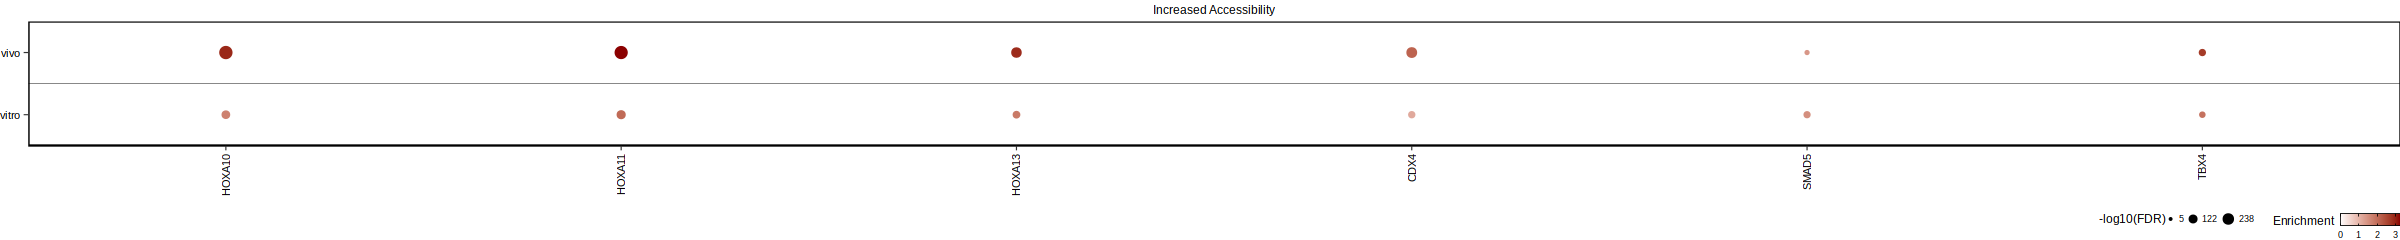

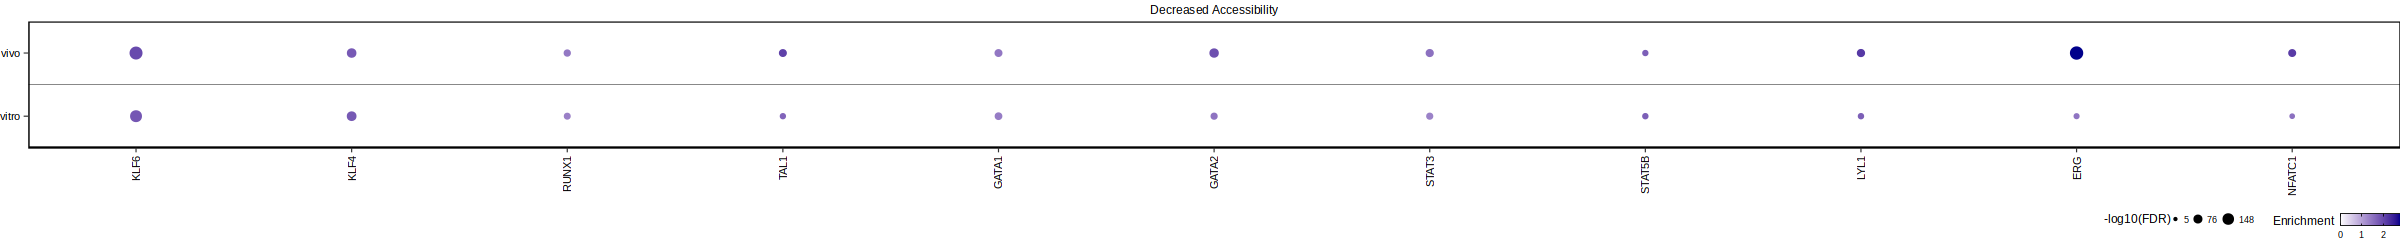

In [148]:
### Plot motif enrichment comparison with atlas
# Motifs in peaks up in allantois or KD
up_vitro = as.data.table(ArchR:::.computeEnrichment(matches, DARs[celltype == args$celltypes & logFC > 0.5 & padj_fdr < 5e-2, peak], seq_len(nrow(matches)))) %>%
        .[,feature := str_split(feature, '_') %>% map_chr(1)] %>% 
        .[mlog10Padj > -log10(0.05)] %>% 
        .[,celltype := 'vitro']

up_vivo = as.data.table(ArchR:::.computeEnrichment(matches, out[logFC > 0.5 & padj_fdr < 5e-2, gene], seq_len(nrow(matches)))) %>%
        .[,feature := str_split(feature, '_') %>% map_chr(1)] %>% 
        .[mlog10Padj > -log10(0.05)] %>% 
        .[,celltype := 'vivo']
up_input = rbind(up_vitro, up_vivo)[,Enrichment := log(Enrichment)][,celltype := factor(celltype, levels = c('vitro', 'vivo'))]

up_plot = plot_enr_heatmap(up_input, ntop = ntop,TFs = c('HOXA10', 'HOXA11', 'HOXA13', 'CDX4', 'SMAD5', 'TBX4'), title = 'Increased Accessibility', color = 'darkred')
up_plot
# Motifs in peaks up in allantois or KD
down_vitro = as.data.table(ArchR:::.computeEnrichment(matches, DARs[celltype == args$celltypes & logFC < 0.5 & padj_fdr < 5e-2, peak], seq_len(nrow(matches)))) %>%
        .[,feature := str_split(feature, '_') %>% map_chr(1)] %>% 
        .[mlog10Padj > -log10(0.05)] %>% 
        .[,celltype := 'vitro']

down_vivo = as.data.table(ArchR:::.computeEnrichment(matches, out[logFC < 0.5 & padj_fdr < 5e-2, gene], seq_len(nrow(matches)))) %>%
        .[,feature := str_split(feature, '_') %>% map_chr(1)] %>% 
        .[mlog10Padj > -log10(0.05)] %>% 
        .[,celltype := 'vivo']
down_input = rbind(down_vitro, down_vivo)[,Enrichment := log(Enrichment)][,celltype := factor(celltype, levels = c('vitro', 'vivo'))]

down_plot = plot_enr_heatmap(down_input, ntop = ntop,TFs = c('KLF6', 'KLF4', 'RUNX1', 'TAL1', 'GATA1', 'GATA2', 'STAT3', 'STAT5B', 'LYL1', 'ERG', 'NFATC1'), title = 'Decreased Accessibility')
down_plot

In [165]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_motifs_wAtlas.pdf'), 
       plot = ggarrange(up_plot + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          NULL, 
          down_plot + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          align = 'h', widths = c(0.7, -0.0, 1), nrow = 1) + 
    theme(plot.margin = unit(c(0,0, 0, 0), 'lines')),
       width = 60, 
       height = 20, 
       units = "mm")

ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_motifs_wAtlas_legend.pdf'), 
       plot = ggarrange(as_ggplot(get_legend(up_plot)), 
                    NULL,
                    as_ggplot(get_legend(down_plot)), ncol = 1, heights = c(1,-0.75,1)),
       width = 70, 
       height = 30, 
       units = "mm")

In [166]:
ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_combined_wAtlas.pdf'), 
       plot = ggarrange(
          p1_wAtlas + theme(legend.position = 'none'), 
          NULL,
          up_plot + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          NULL, 
          down_plot + theme(axis.text.y = element_blank(), legend.position = 'none'), 
          align = 'h', widths = c(3, 0.01, 0.6, 0.01, 1), ncol = 5) + 
    theme(plot.margin = unit(c(0,0, 0, 0), 'lines')),
       width = 150, 
       height = 25, 
       units = "mm")

### RNA & ATAC

In [12]:
# Add multiome atlas expression to rna object for plotting
atlas_endo = readRDS(args$atlas_sce)

atlas_endo$genotype = 'Atlas'
atlas_endo$celltype_v2 = atlas_endo$seurat_cluster

genes = intersect(rownames(atlas_endo), rownames(rna.sce))

colData(rna.sce) = colData(rna.sce)[,c('genotype', 'celltype_v2')]
colData(atlas_endo) = colData(atlas_endo)[,c('genotype', 'celltype_v2')]

rna.sce = cbind(rna.sce[genes,], atlas_endo[genes,])

In [13]:
# link DEGs & DARs
DEG_DAR = DEGs %>% copy() %>%  
                    .[!is.na(logFC)] %>% 
                   setnames(colnames(.)[2:7], paste0('RNA_', colnames(.)[2:7])) %>% 
          merge(., peak_gene_correlation[,c('peak', 'gene', 'cor', 'padj')], 
                by = 'gene') %>% 
          merge(., DARs %>% copy() %>%  
                    .[!is.na(logFC)] %>% 
                   setnames(colnames(.)[2:7], paste0('ATAC_', colnames(.)[2:7])),
                by = c('celltype', 'peak'))

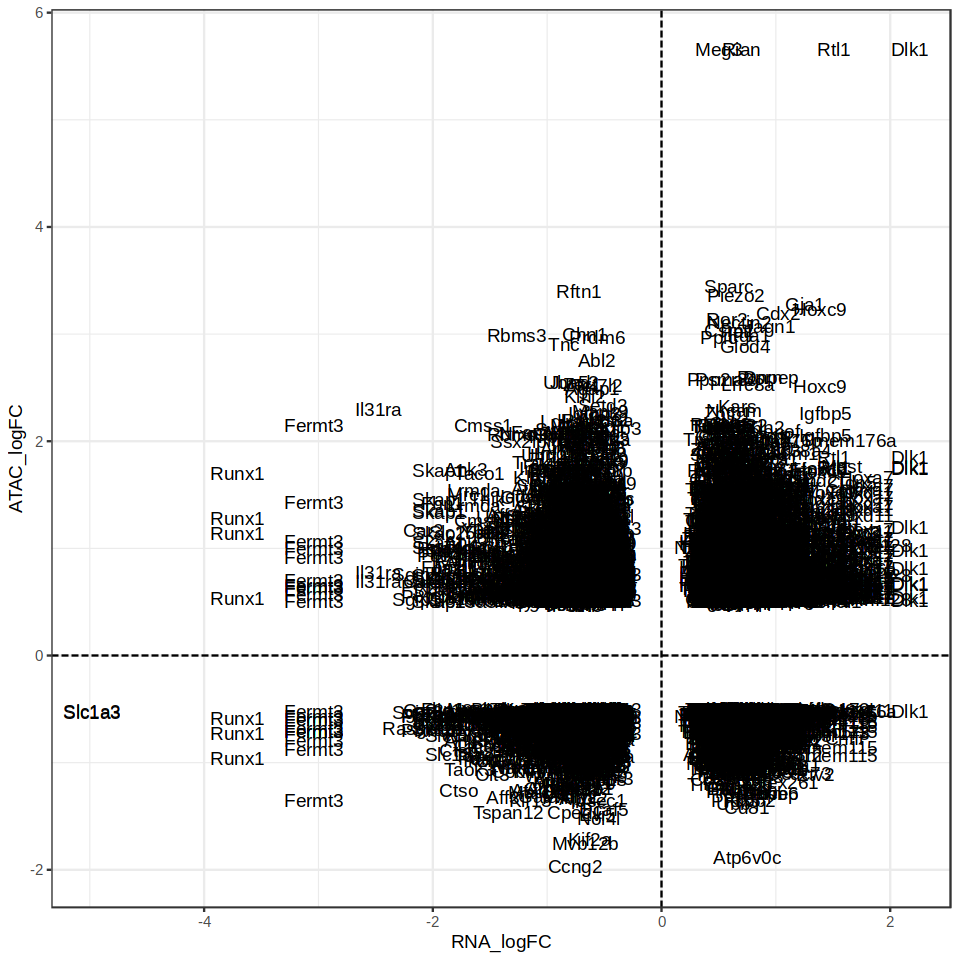

In [66]:
options(repr.plot.width=8, repr.plot.height=8)
ggplot(DEG_DAR[celltype == args$celltypes], aes(RNA_logFC, ATAC_logFC)) + 
    geom_text(aes(label = gene)) + 
    geom_hline(yintercept = 0, linetype = 'longdash') + 
    geom_vline(xintercept = 0, linetype = 'longdash') + 
    theme_bw()

In [9]:
WT_plot = WT_plot %>% 
    .[, name := gsub('YS_endothelium \\(Atlas\\)', 'YS Endoth.', name)] %>% 
    .[, name := gsub('Allantois_endothelium \\(Atlas\\)', 'Allantois Endoth.', name)]

In [35]:
source(here::here('utils.R'))

p1 = plot_region('Dlk1', bw_width = 30, bw_height = 7, gene_height = 6, extend.downstream = -4.5e4, extend.upstream = -3.5e4, expr_width = 4)
p2 = plot_region('Jag1', bw_width = 25, bw_height = 7, gene_height = 6, no_label = T, extend.downstream = -1.5e5, extend.upstream = 1.5e4, expr_width = 4)
p3 = plot_region('Runx1', bw_width = 30, bw_height = 7, gene_height = 6, no_label = T, extend.downstream = -1e5, expr_width = 4)
p4 = plot_region('Igf1', bw_width = 30, bw_height = 7, gene_height = 6, no_label = T, extend.downstream = -9.5e4, extend.upstream = 0, expr_width = 4)

ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_GB.pdf'), 
       plot = patchwork::wrap_plots(plotlist = list(p1,p2, p3, p4), 
                                      nrow = 1),
       width = 200, 
       height = 40, 
       units = "mm")

In [16]:
options(repr.plot.width = 25, repr.plot.height=8)
source(here::here('utils.R'))


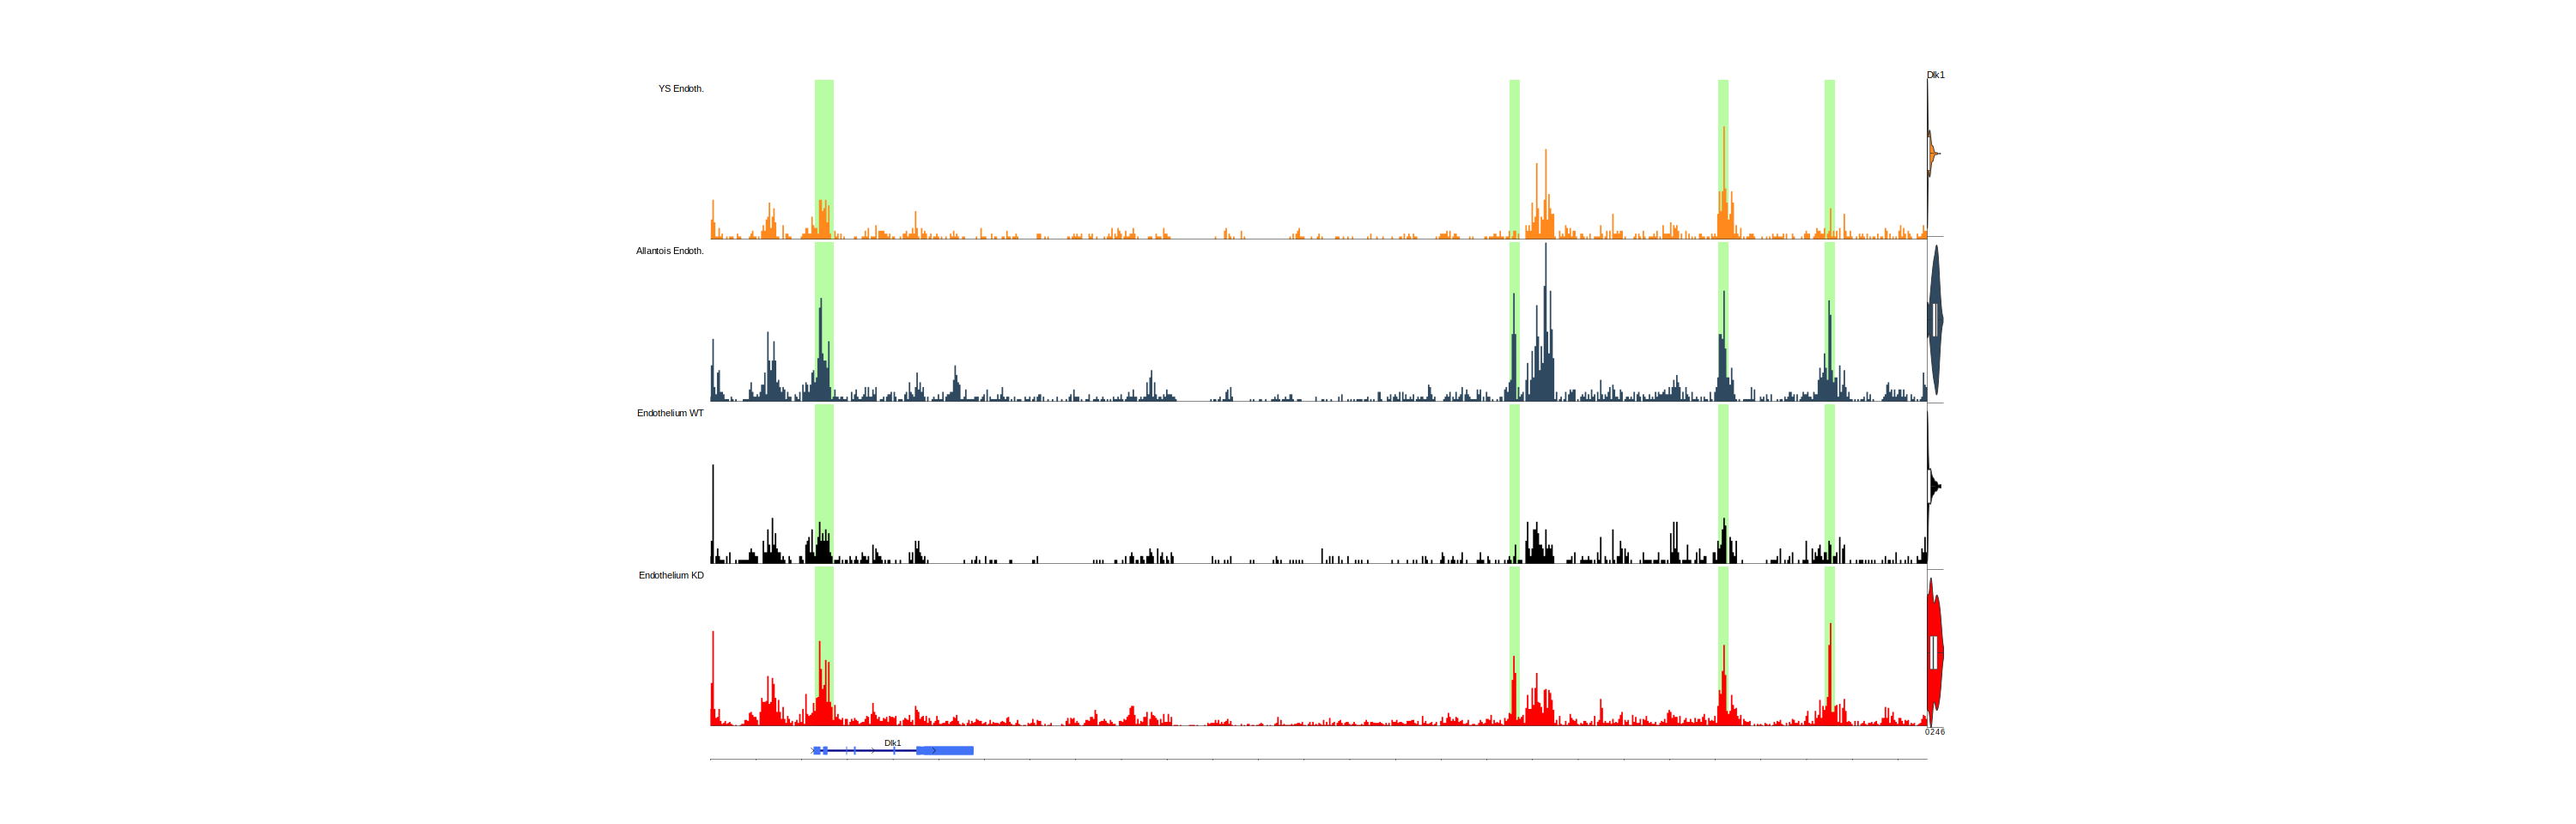

In [17]:
p1 = plot_region('Dlk1', bw_width = 300, bw_height = 40, gene_height = 6, extend.downstream = -4.5e4, extend.upstream = -3.5e4, expr_width = 4)
p1

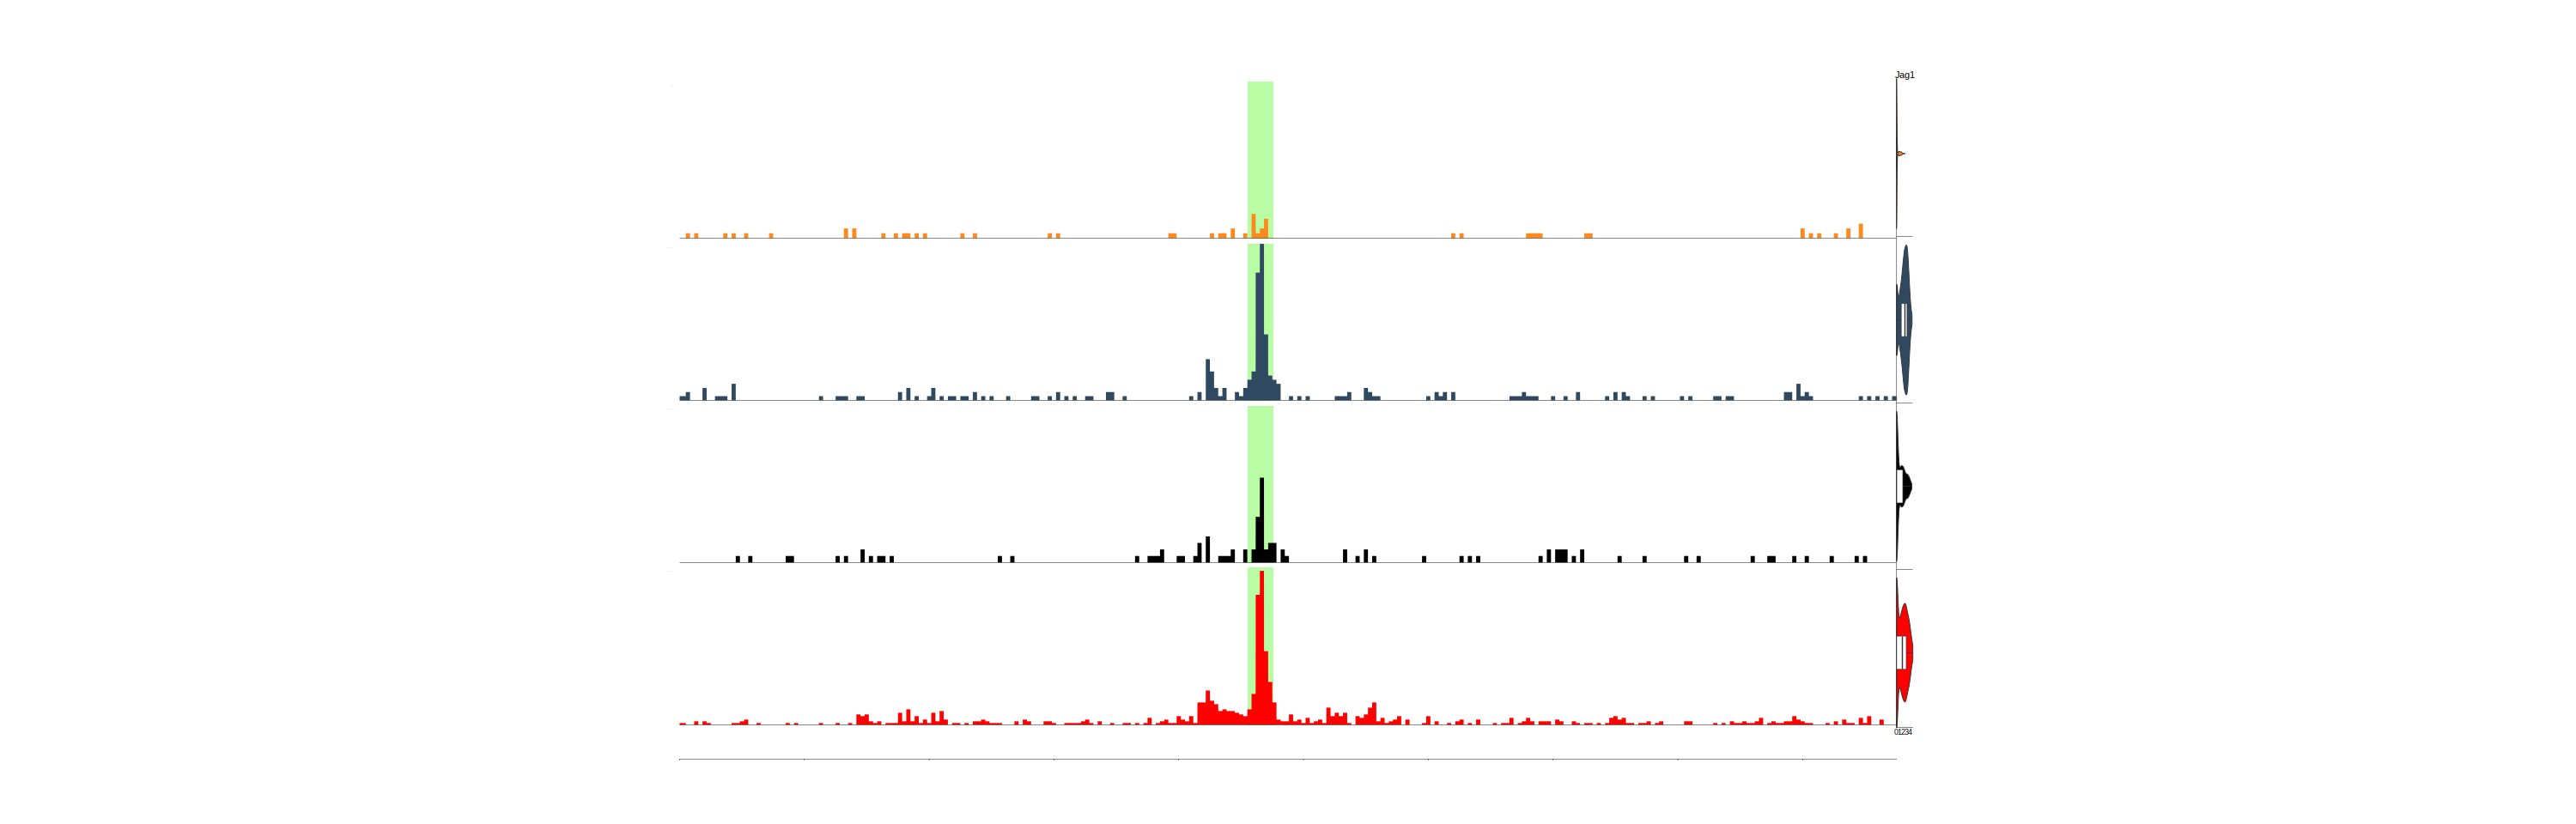

In [25]:
p2 = plot_region('Jag1', bw_width = 300, bw_height = 40, gene_height = 6, no_label = T, extend.downstream = -1.5e5, extend.upstream = 1.5e4, expr_width = 4)
p2

In [ ]:
p3 = plot_region('Runx1', bw_width = 300, bw_height = 40, gene_height = 6, no_label = T, extend.downstream = -1e5, expr_width = 4)
p3

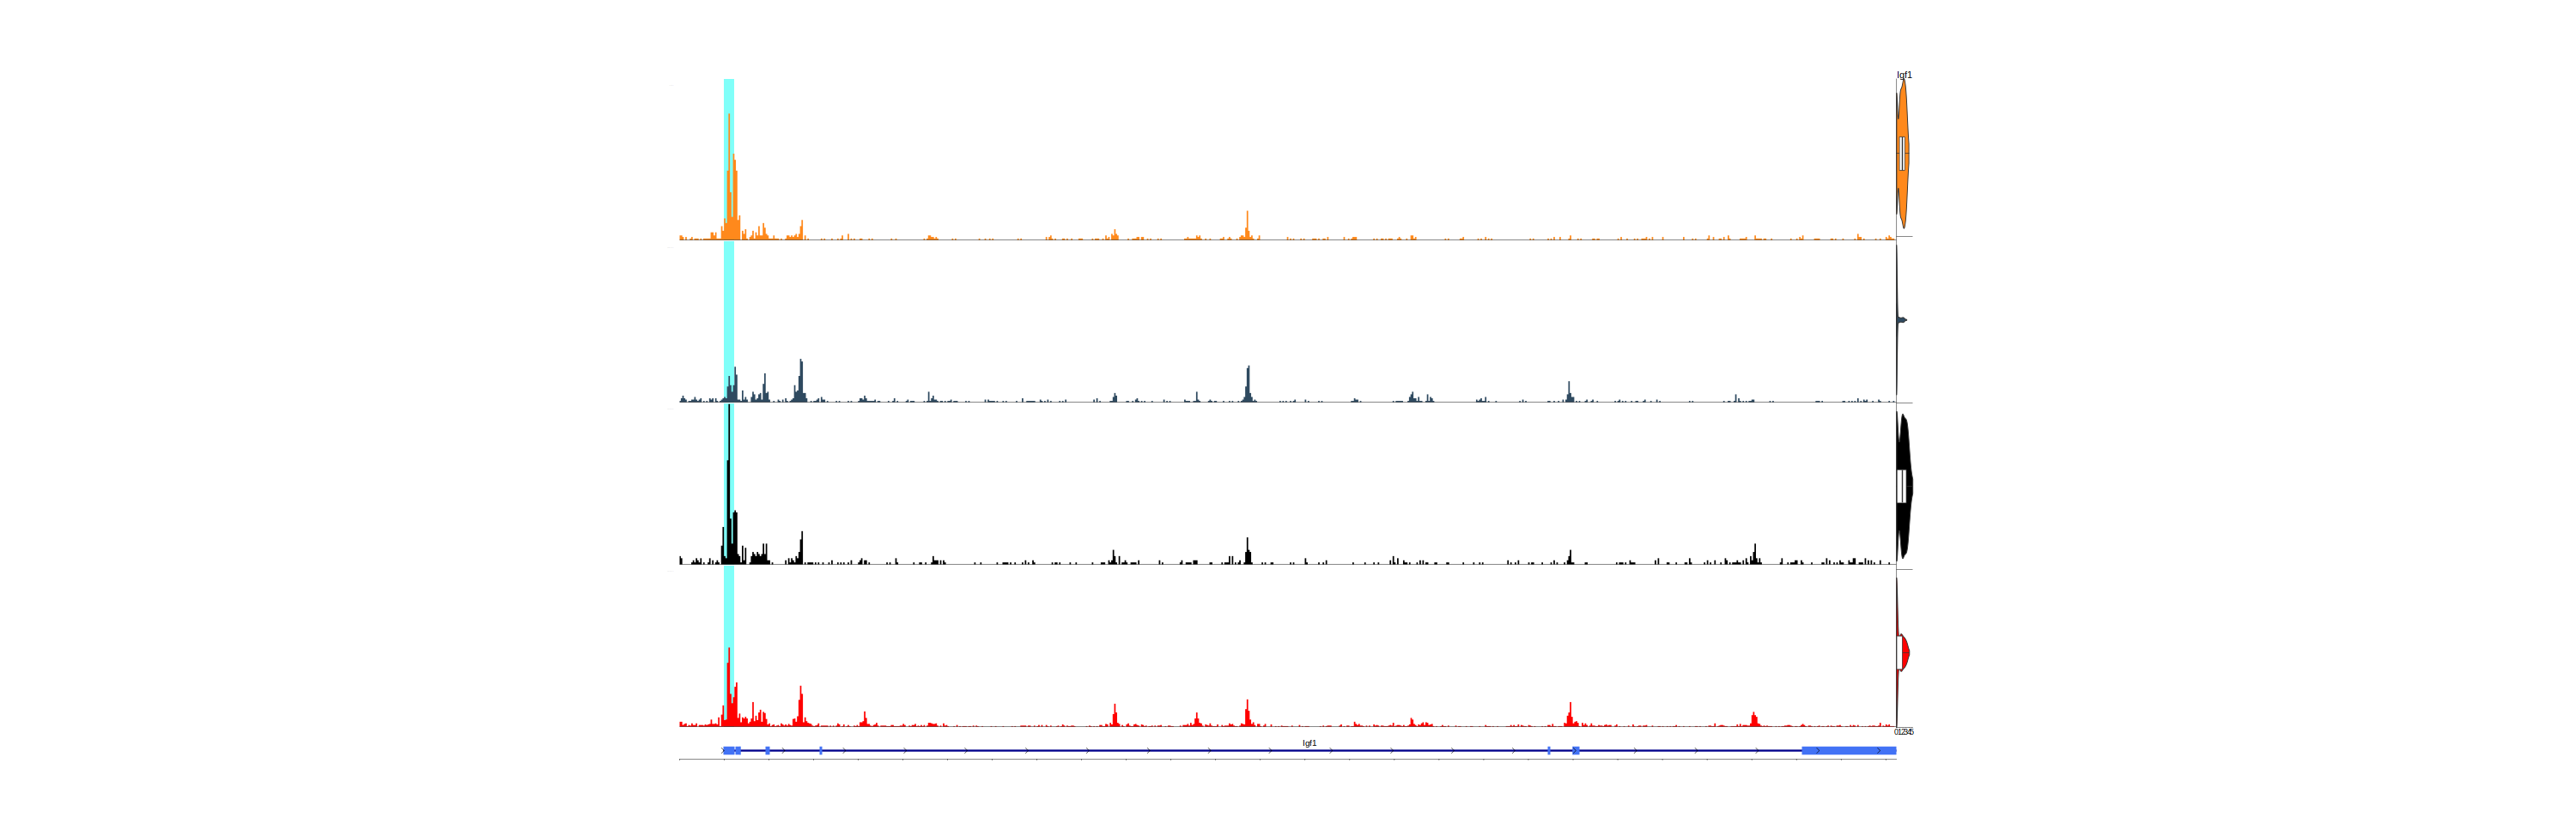

In [34]:
p4 = plot_region('Igf1', bw_width = 300, bw_height = 40, gene_height = 6, no_label = T,extend.downstream = -9.5e4, extend.upstream = 0, expr_width = 4)
p4

In [85]:
source(here::here('utils.R'))

p1 = plot_region('Hoxa11', bw_width = 45, bw_height = 9, gene_height = 6, extend.downstream = -1.1e5, extend.upstream = -5e4, , expr_width = 0)

ggsave(file.path(io$basedir, 'figures/multiome_KD_Endo_GB_supp.pdf'), 
       plot = p1,
       width = 70, 
       height = 53, 
       units = "mm")

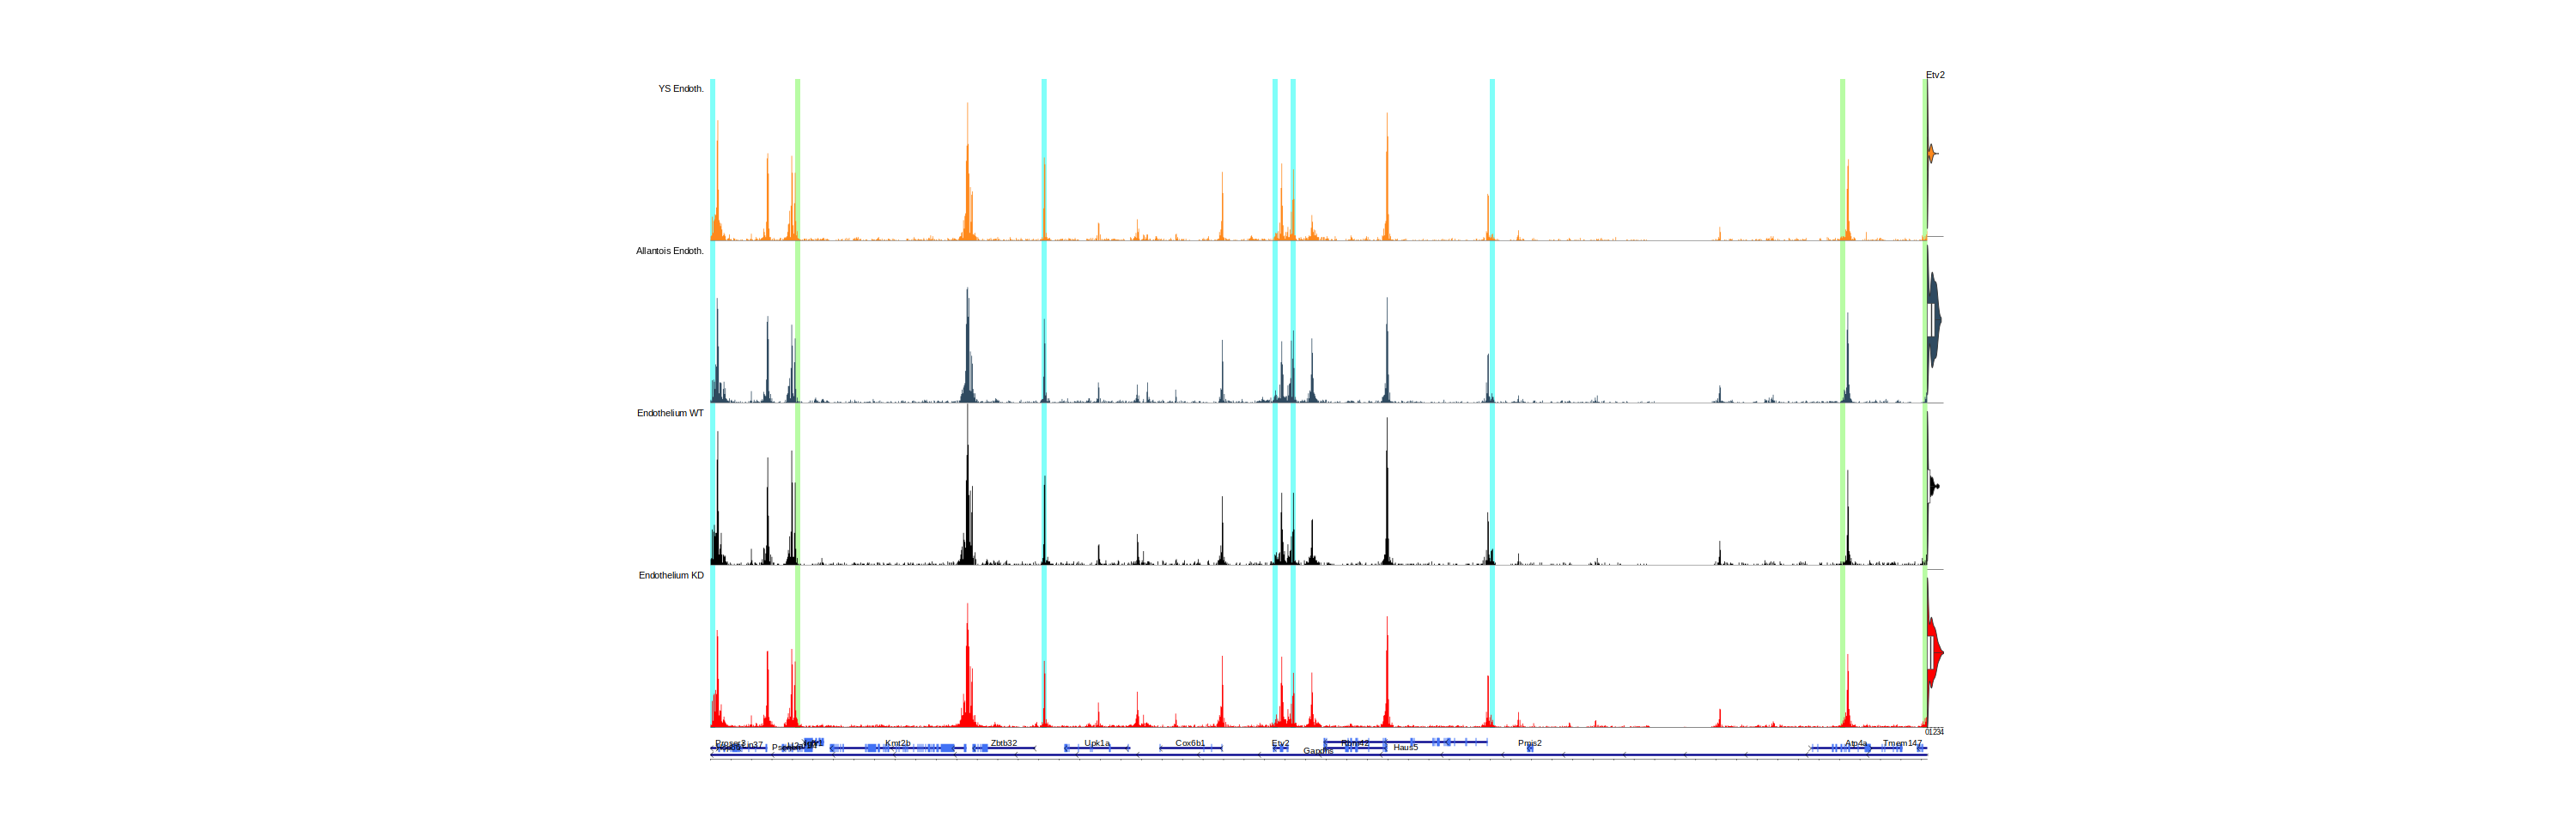

In [86]:
options(repr.plot.width = 25, repr.plot.height=8)
p1 = plot_region('Etv2', bw_width = 300, bw_height = 40, gene_height = 6, extend.downstream = 0, extend.upstream = 0, expr_width = 4)
p1

In [103]:
args$celltypes = c('Primitive_Streak','Early_Mes_EOi')

In [104]:
# Load differential RNA
DEGs = fread(sprintf('%s/DEGs_edgeR_pb.txt.gz', args$expression))[celltype %in% args$celltypes] %>% 
        .[,sig:=ifelse(abs(logFC)>0.5 & padj_fdr < 0.05, TRUE, FALSE)] %>% 
        .[sig == T] %>% .[, sig := NULL]
DEGs = DEGs[!gene %in% c('Hba-x', 'Hba-a1', 'Hba-a2', 'Hbb-bh1')]

# Load differential ATAC
DARs = fread(sprintf('%s/DARs_edgeR_pb.txt.gz', args$accessibility))[celltype %in% args$celltypes] %>% 
        .[,sig:=ifelse(abs(logFC)>0.5 & padj_fdr < 0.05, TRUE, FALSE)] %>% 
        .[sig == T] %>% .[, sig := NULL]

# link DEGs & DARs
DEG_DAR = DEGs %>% copy() %>%  
                    .[!is.na(logFC)] %>% 
                   setnames(colnames(.)[2:7], paste0('RNA_', colnames(.)[2:7])) %>% 
          merge(., peak_gene_correlation[,c('peak', 'gene', 'cor', 'padj')], 
                by = 'gene') %>% 
          merge(., DARs %>% copy() %>%  
                    .[!is.na(logFC)] %>% 
                   setnames(colnames(.)[2:7], paste0('ATAC_', colnames(.)[2:7])),
                by = c('celltype', 'peak'))

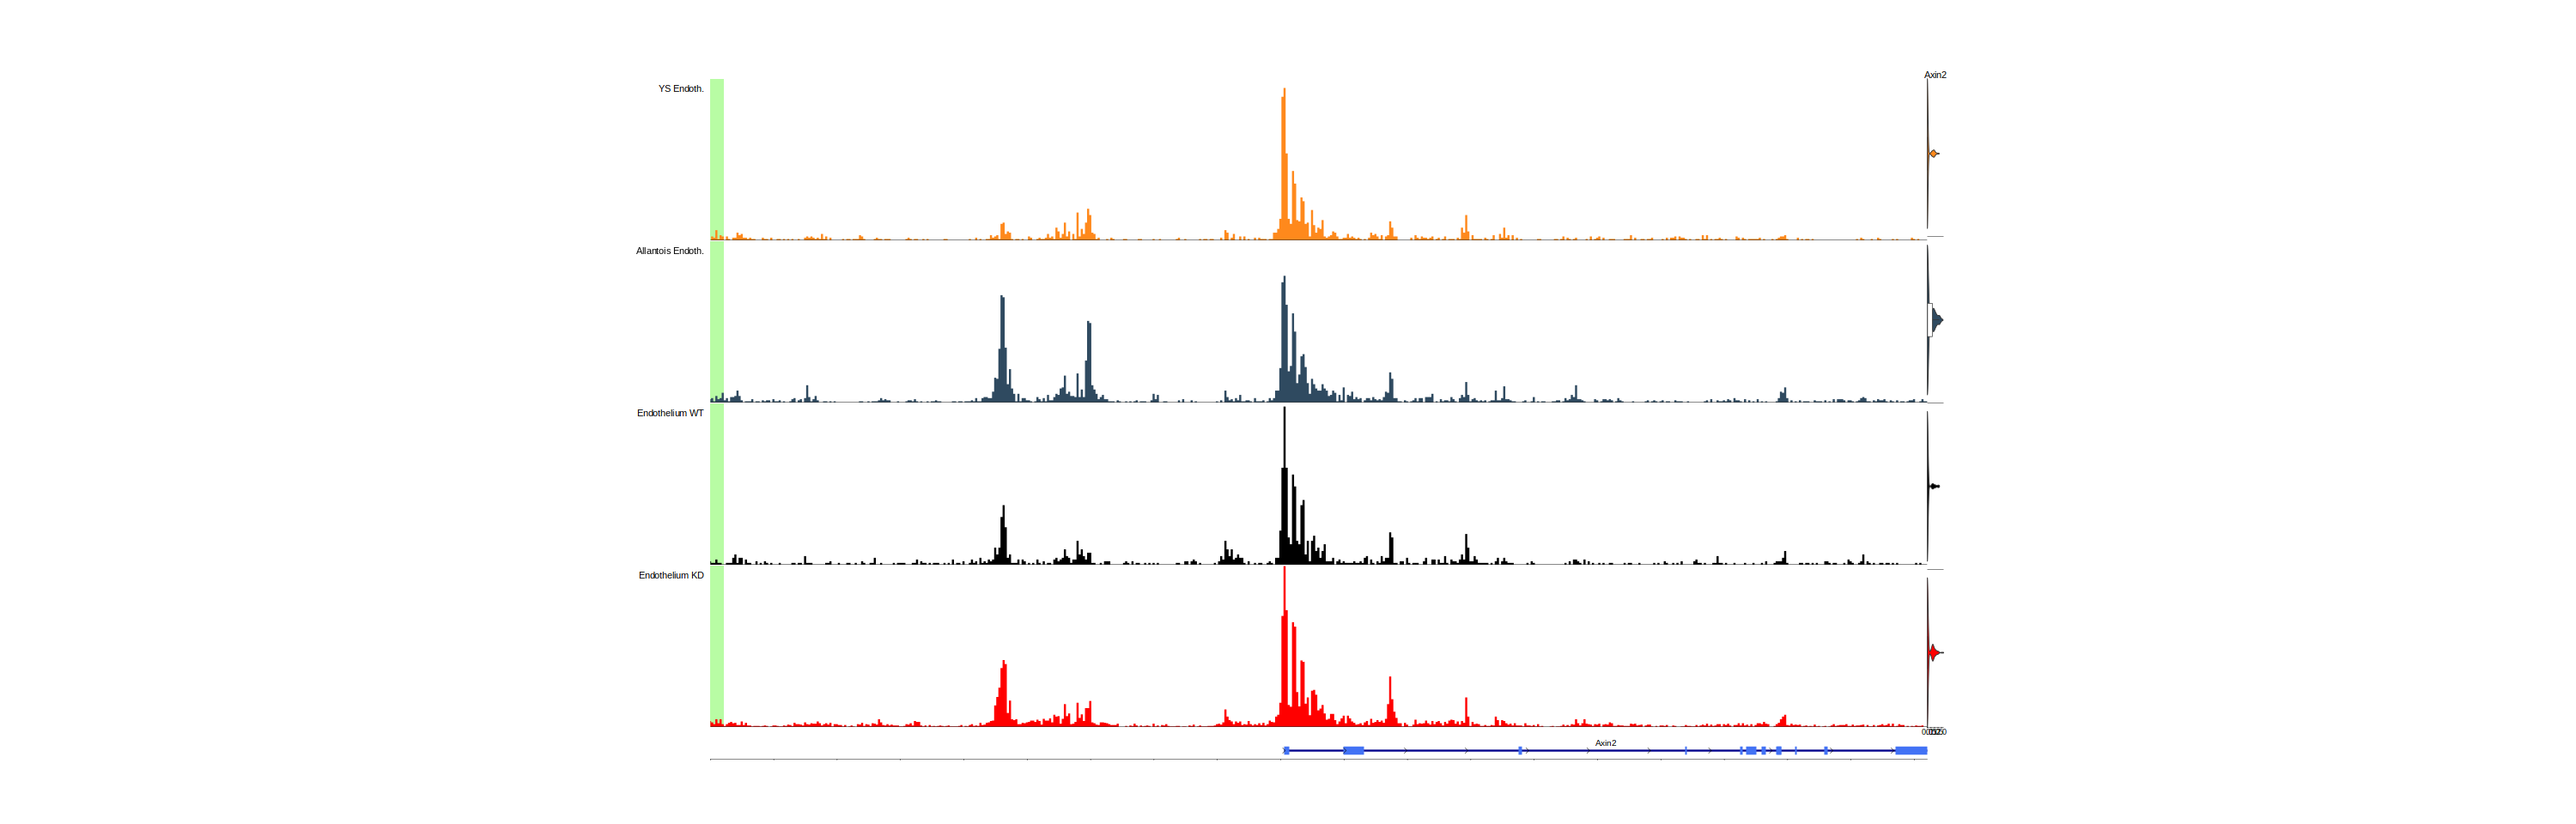

In [111]:
options(repr.plot.width = 25, repr.plot.height=8)
p1 = plot_region('Axin2', bw_width = 300, bw_height = 40, gene_height = 6, extend.downstream = 0, extend.upstream = 0, expr_width = 4)
p1

In [ ]:
bigwigs.data

celltype,genotype,path,name,color
<chr>,<chr>,<chr>,<chr>,<chr>
Allantois_Precursor,KO,/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupBigWigs/celltypeV2_genotype/Allantois_Precursor.KO-TileSize-100-normMethod-ReadsInTSS-ArchR.bw,Allantois_Precursor KD,#FF0000
Allantois_Precursor,WT,/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupBigWigs/celltypeV2_genotype/Allantois_Precursor.WT-TileSize-100-normMethod-ReadsInTSS-ArchR.bw,Allantois_Precursor WT,#000000
Allantois,KO,/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupBigWigs/celltypeV2_genotype/Allantois.KO-TileSize-100-normMethod-ReadsInTSS-ArchR.bw,Allantois KD,#FF0000
Allantois,WT,/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupBigWigs/celltypeV2_genotype/Allantois.WT-TileSize-100-normMethod-ReadsInTSS-ArchR.bw,Allantois WT,#000000
Blood_Progenitor,KO,/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupBigWigs/celltypeV2_genotype/Blood_Progenitor.KO-TileSize-100-normMethod-ReadsInTSS-ArchR.bw,Blood_Progenitor KD,#FF0000
Blood_Progenitor,WT,/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupBigWigs/celltypeV2_genotype/Blood_Progenitor.WT-TileSize-100-normMethod-ReadsInTSS-ArchR.bw,Blood_Progenitor WT,#000000
Early_Mes_EOd,KO,/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupBigWigs/celltypeV2_genotype/Early_Mes_EOd.KO-TileSize-100-normMethod-ReadsInTSS-ArchR.bw,Early_Mes_EOd KD,#FF0000
Early_Mes_EOd,WT,/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupBigWigs/celltypeV2_genotype/Early_Mes_EOd.WT-TileSize-100-normMethod-ReadsInTSS-ArchR.bw,Early_Mes_EOd WT,#000000
Early_Mes_EOi,KO,/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/processed/atac/archR/GroupBigWigs/celltypeV2_genotype/Early_Mes_EOi.KO-TileSize-100-normMethod-ReadsInTSS-ArchR.bw,Early_Mes_EOi KD,#FF0000


In [147]:

bigwig_order = c(#'Unknown_endothelium (Atlas)',
                 #'EP_endothelium (Atlas)',
                 'Allantois WT',
    'Allantois KD',
                 'Endothelium WT',
                 'Endothelium KD',
    'HE WT',
    'HE KD',
    'Early_Mes_EOi WT',
    'Early_Mes_EOi KD',
    'Early_Mes_EOd WT',
    'Early_Mes_EOd KD'
                 #'Allantois-WT'
                )

WT_plot = bigwigs.data %>% copy() %>%
    .[match(bigwig_order, name)] %>% 
    .[, name := factor(name, levels = bigwig_order)]

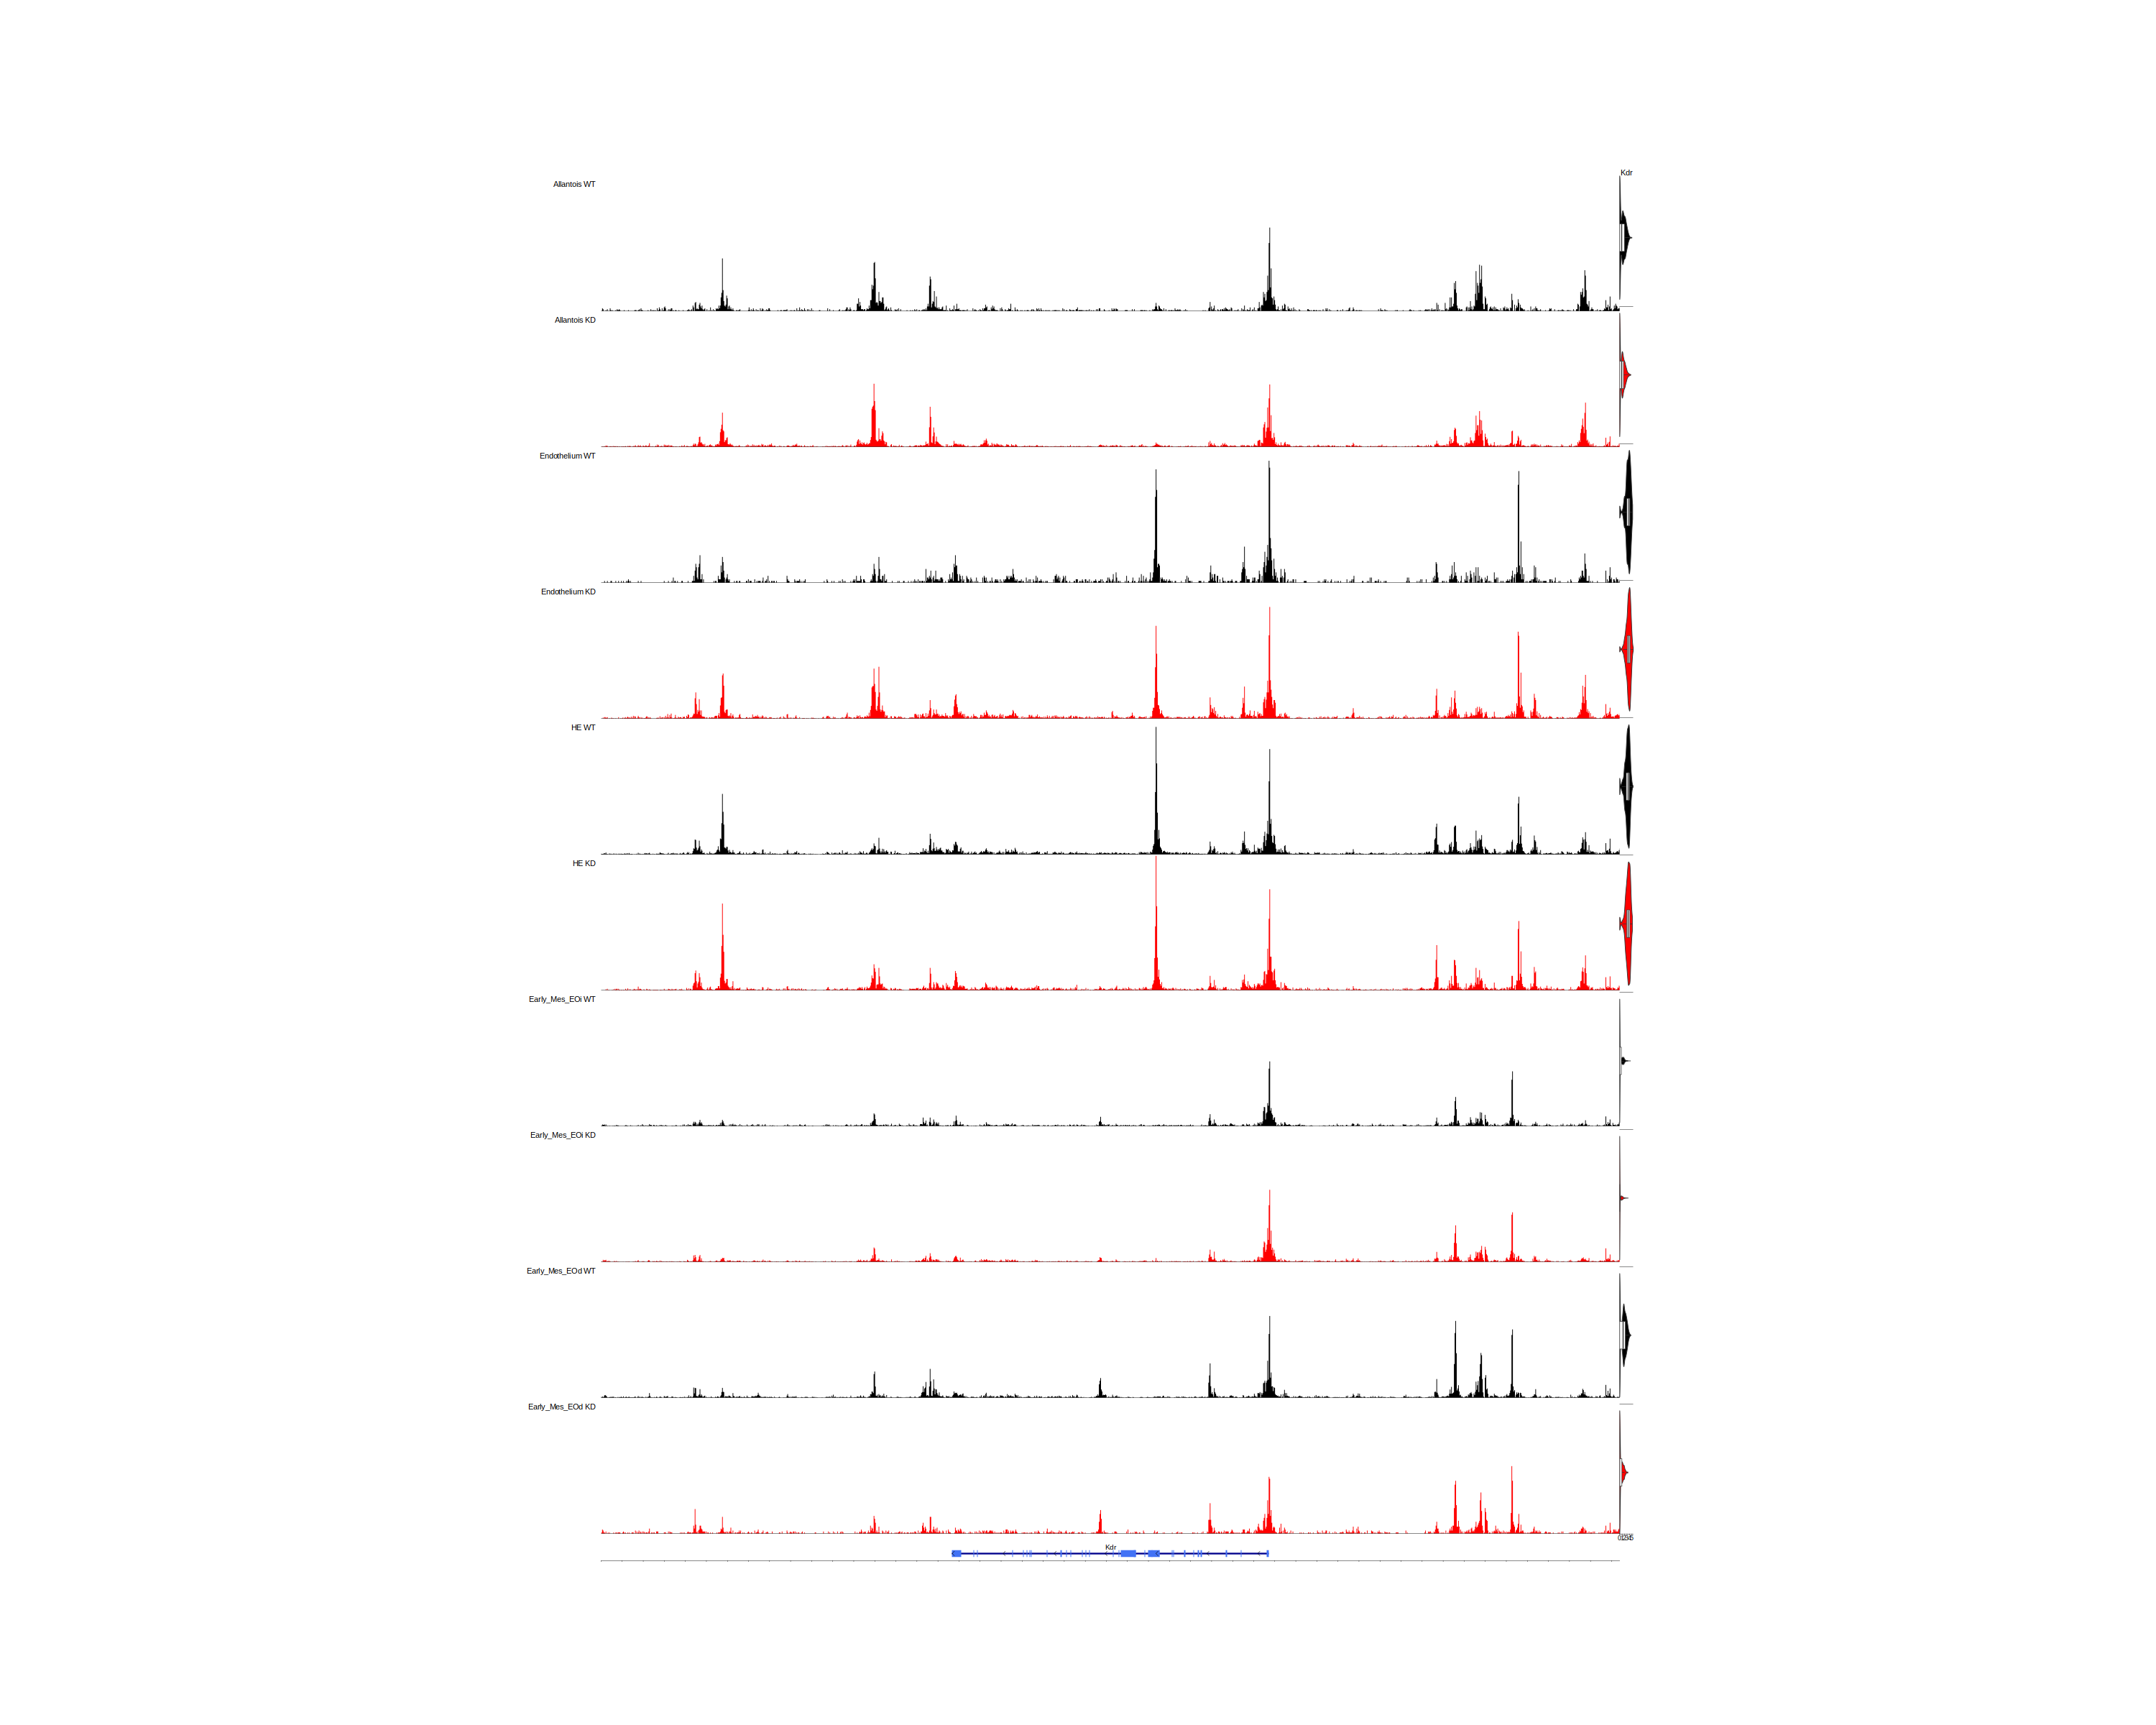

In [155]:
options(repr.plot.width = 25, repr.plot.height=20)
p1 = plot_region('Kdr', bw_width = 300, bw_height = 40, gene_height = 6, extend.downstream = 5e4, extend.upstream = 5e4, expr_width = 4)
p1